🔬 LAB: Model Monitoring with Scikit-Learn
การติดตามและเฝ้าระวังโมเดล Machine Learning

📚 บทนำ (Introduction)

## Model Monitoring คืออะไร?

Model Monitoring คือกระบวนการติดตามและเฝ้าระวังประสิทธิภาพของโมเดล Machine Learning
หลังจากที่ได้ deploy ไปใช้งานจริง (Production) เพื่อให้มั่นใจว่าโมเดลยังคงทำงานได้อย่างถูกต้อง

## ทำไมต้อง Monitor โมเดล?

1. Data Drift - ข้อมูลในโลกจริงเปลี่ยนแปลงตลอดเวลา
2. Concept Drift - ความสัมพันธ์ระหว่าง features และ target เปลี่ยนไป
3. Model Degradation - ประสิทธิภาพโมเดลลดลงเมื่อเวลาผ่านไป
4. Data Quality Issues - ปัญหาคุณภาพข้อมูล เช่น missing values, outliers

## สิ่งที่จะเรียนรู้ใน LAB นี้

- ✅ Data Quality Monitoring
- ✅ Model Performance Tracking
- ✅ Target Drift Detection
- ✅ Building Monitoring Dashboard

---
# 🛠️ Section 0: Environment Setup
## การติดตั้งและเตรียมสภาพแวดล้อม

In [1]:
# ติดตั้ง libraries ที่จำเป็น (รันครั้งเดียว)
!pip install scikit-learn pandas numpy matplotlib seaborn scipy

In [2]:
# Import libraries ที่จำเป็น
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

# Statistical tests
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency, wasserstein_distance

# ตั้งค่า display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 10

print("✅ Import libraries สำเร็จ!")
print(f"📅 วันที่รัน: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Import libraries สำเร็จ!
📅 วันที่รัน: 2026-01-07 04:01:49


---
# 📊 Section 1: Data Quality Monitoring
## การตรวจสอบคุณภาพข้อมูล

ทฤษฎี:

Data Quality Monitoring เป็นขั้นตอนแรกและสำคัญที่สุดในการ monitor โมเดล
เพราะ "Garbage In, Garbage Out" - ถ้าข้อมูลไม่ดี โมเดลก็ไม่สามารถทำนายได้ดี

สิ่งที่ต้องตรวจสอบ:
1. Missing Values - ค่าที่หายไป
2. Duplicates - ข้อมูลซ้ำ
3. Data Types - ประเภทข้อมูล
4. Value Ranges - ช่วงค่าของข้อมูล
5. Outliers - ค่าผิดปกติ

## 1.1 สร้างข้อมูลตัวอย่าง (Synthetic Data)

เราจะสร้างข้อมูลจำลองสำหรับปัญหา Credit Risk Classification
โดยมี 2 ชุด:
- Reference Data - ข้อมูลที่ใช้ train โมเดล (ข้อมูลในอดีต)
- Current Data - ข้อมูลใหม่ที่เข้ามา (ข้อมูลปัจจุบัน)

In [3]:
def create_credit_data(n_samples=1000, seed=42, drift_level=0.0):
    """
    สร้างข้อมูล Credit Risk จำลอง
    
    Parameters:
    -----------
    n_samples : int - จำนวนตัวอย่าง
    seed : int - random seed
    drift_level : float - ระดับ drift (0.0 = ไม่มี drift, 1.0 = drift มาก)

    Returns:
    --------
    DataFrame - ข้อมูล credit risk
    """
    np.random.seed(seed)

    # สร้าง features
    data = {
        'customer_id': range(1, n_samples + 1),
        'age': np.random.normal(35 + drift_level * 5, 10, n_samples).astype(int),
        'income': np.random.normal(50000 + drift_level * 10000, 15000, n_samples),
        'loan_amount': np.random.normal(20000 + drift_level * 5000, 8000, n_samples),
        'credit_score': np.random.normal(650 - drift_level * 30, 80, n_samples).astype(int),
        'employment_years': np.random.exponential(5 + drift_level, n_samples),
        'num_credit_cards': np.random.poisson(3, n_samples),
        'debt_to_income': np.random.uniform(0.1 + drift_level * 0.1, 0.6 + drift_level * 0.1, n_samples),
        'previous_defaults': np.random.binomial(3, 0.1 + drift_level * 0.05, n_samples),
        'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 
                                       n_samples, p=[0.3, 0.4, 0.2, 0.1]),
        'employment_type': np.random.choice(['Full-time', 'Part-time', 'Self-employed', 'Unemployed'],
                                            n_samples, p=[0.6, 0.15, 0.2, 0.05])
    }

    df = pd.DataFrame(data)

    # จำกัดค่าให้อยู่ในช่วงที่เหมาะสม
    df['age'] = df['age'].clip(18, 80)
    df['credit_score'] = df['credit_score'].clip(300, 850)
    df['income'] = df['income'].clip(10000, 200000)
    df['loan_amount'] = df['loan_amount'].clip(1000, 100000)
    df['employment_years'] = df['employment_years'].clip(0, 40)

    # สร้าง target (default: 1 = ผิดนัดชำระ, 0 = ไม่ผิดนัด)
    default_prob = (
        0.1 +
        0.02 * (df['debt_to_income'] - 0.3) * 10 +
        0.01 * df['previous_defaults'] +
        -0.001 * (df['credit_score'] - 600) +
        -0.0001 * (df['income'] - 40000) +
        drift_level * 0.1
    )
    default_prob = default_prob.clip(0.01, 0.99)
    df['default'] = (np.random.random(n_samples) < default_prob).astype(int)

    return df


# สร้าง Reference Data (ข้อมูลในอดีต - ไม่มี drift)
print("📊 กำลังสร้างข้อมูลตัวอย่าง...")
reference_data = create_credit_data(n_samples=2000, seed=42, drift_level=0.0)
print(f"✅ Reference Data: {len(reference_data)} rows")

# สร้าง Current Data (ข้อมูลปัจจุบัน - มี drift เล็กน้อย)
current_data = create_credit_data(n_samples=1000, seed=123, drift_level=0.3)
print(f"✅ Current Data: {len(current_data)} rows")

# แสดงตัวอย่างข้อมูล
print("\n📋 ตัวอย่าง Reference Data:")
reference_data.head()

📊 กำลังสร้างข้อมูลตัวอย่าง...
✅ Reference Data: 2000 rows
✅ Current Data: 1000 rows

📋 ตัวอย่าง Reference Data:


,customer_id,age,income,loan_amount,credit_score,employment_years,num_credit_cards,debt_to_income,previous_defaults,education,employment_type,default
0,1,39,39872.325875,13092.051160,560,0.161876,4,0.220356,0,Master,Full-time,1
1,2,33,47832.219939,19750.372088,599,3.167820,1,0.272722,1,High School,Full-time,0
2,3,41,38113.701185,20144.134976,574,12.926253,0,0.516573,1,Master,Self-employed,1
3,4,50,45380.577055,23781.042767,606,2.534101,1,0.283196,1,Bachelor,Full-time,0
4,5,32,21595.779996,9065.133094,632,4.903113,2,0.477311,0,Bachelor,Full-time,1


In [4]:
# แสดงข้อมูลเบื้องต้น
print("=" * 60)
print("📊 REFERENCE DATA INFO")
print("=" * 60)
print(f"Shape: {reference_data.shape}")
print(f"\nData Types:\n{reference_data.dtypes}")
print(f"\nTarget Distribution:\n{reference_data['default'].value_counts(normalize=True)}")

📊 REFERENCE DATA INFO
Shape: (2000, 12)

Data Types:
customer_id            int64
age                    int64
income               float64
loan_amount          float64
credit_score           int64
employment_years     float64
num_credit_cards       int64
debt_to_income       float64
previous_defaults      int64
education             object
employment_type       object
default                int64
dtype: object

Target Distribution:
default
0    0.8125
1    0.1875
Name: proportion, dtype: float64


## 1.2 สร้าง Data Quality Report Class

เราจะสร้าง class สำหรับตรวจสอบคุณภาพข้อมูลอย่างครบถ้วน

In [5]:
class DataQualityMonitor:
    """
    Class สำหรับตรวจสอบคุณภาพข้อมูล
    
    ใช้สำหรับ:
    - ตรวจสอบ missing values
    - ตรวจสอบ duplicates
    - วิเคราะห์ data integrity
    - สร้าง quality report
    """

    def __init__(self, data, data_name="Data"):
        """
        Parameters:
        -----------
        data : DataFrame - ข้อมูลที่ต้องการตรวจสอบ
        data_name : str - ชื่อของชุดข้อมูล
        """
        self.data = data.copy()
        self.data_name = data_name
        self.report = {}
        
    def check_missing_values(self):
        """ตรวจสอบ missing values"""
        missing = self.data.isnull().sum()
        missing_pct = (missing / len(self.data) * 100).round(2)
        
        missing_df = pd.DataFrame({
            'column': missing.index,
            'missing_count': missing.values,
            'missing_percentage': missing_pct.values
        })
        missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(
            'missing_percentage', ascending=False
        )
        
        self.report['missing_values'] = {
            'total_missing': int(missing.sum()),
            'columns_with_missing': len(missing_df),
            'details': missing_df.to_dict('records')
        }
        
        return missing_df

    def check_duplicates(self):
        """ตรวจสอบข้อมูลซ้ำ"""
        # ตรวจสอบ duplicate rows ทั้งหมด
        duplicate_rows = self.data.duplicated().sum()
        
        # ตรวจสอบ duplicate ตาม ID (ถ้ามี)
        id_columns = [col for col in self.data.columns if 'id' in col.lower()]
        duplicate_ids = {}
        
        for id_col in id_columns:
            dup_count = self.data[id_col].duplicated().sum()
            if dup_count > 0:
                duplicate_ids[id_col] = int(dup_count)
        
        self.report['duplicates'] = {
            'duplicate_rows': int(duplicate_rows),
            'duplicate_percentage': round(duplicate_rows / len(self.data) * 100, 2),
            'duplicate_ids': duplicate_ids
        }
        
        return self.report['duplicates']

    def check_data_types(self):
        """ตรวจสอบประเภทข้อมูล"""
        dtypes_df = pd.DataFrame({
            'column': self.data.columns,
            'dtype': self.data.dtypes.values,
            'unique_values': [self.data[col].nunique() for col in self.data.columns],
            'sample_values': [str(self.data[col].dropna().head(3).tolist()) for col in self.data.columns]
        })
        
        # จำแนกประเภท columns
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = self.data.select_dtypes(include=['object', 'category']).columns.tolist()
        
        self.report['data_types'] = {
            'numeric_columns': numeric_cols,
            'categorical_columns': categorical_cols,
            'total_columns': len(self.data.columns)
        }
        
        return dtypes_df

    def check_value_ranges(self):
        """ตรวจสอบช่วงค่าของข้อมูล numeric"""
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        
        range_stats = []
        for col in numeric_cols:
            stats_dict = {
                'column': col,
                'min': self.data[col].min(),
                'max': self.data[col].max(),
                'mean': round(self.data[col].mean(), 2),
                'median': round(self.data[col].median(), 2),
                'std': round(self.data[col].std(), 2),
                'q1': round(self.data[col].quantile(0.25), 2),
                'q3': round(self.data[col].quantile(0.75), 2)
            }
            range_stats.append(stats_dict)
        
        self.report['value_ranges'] = range_stats
        return pd.DataFrame(range_stats)

    def detect_outliers(self, method='iqr', threshold=1.5):
        """
        ตรวจหา outliers ด้วยวิธี IQR
        
        Parameters:
        -----------
        method : str - วิธีการตรวจหา ('iqr' หรือ 'zscore')
        threshold : float - ค่า threshold (1.5 สำหรับ IQR, 3 สำหรับ z-score)
        """
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        outlier_info = []
        
        for col in numeric_cols:
            if method == 'iqr':
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)]
            else:  # z-score
                z_scores = np.abs(stats.zscore(self.data[col].dropna()))
                outliers = self.data[z_scores > threshold]
            
            outlier_count = len(outliers)
            outlier_pct = round(outlier_count / len(self.data) * 100, 2)
            
            outlier_info.append({
                'column': col,
                'outlier_count': outlier_count,
                'outlier_percentage': outlier_pct,
                'method': method,
                'threshold': threshold
            })
        
        self.report['outliers'] = outlier_info
        return pd.DataFrame(outlier_info)

    def generate_full_report(self):
        """สร้าง report ฉบับเต็ม"""
        print("=" * 70)
        print(f"📊 DATA QUALITY REPORT: {self.data_name}")
        print("=" * 70)
        print(f"📅 Generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📁 Total Records: {len(self.data):,}")
        print(f"📋 Total Columns: {len(self.data.columns)}")
        print()
        
        # 1. Missing Values
        print("-" * 50)
        print("1️⃣ MISSING VALUES CHECK")
        print("-" * 50)
        missing_df = self.check_missing_values()
        if len(missing_df) > 0:
            print(f"⚠️ พบ {self.report['missing_values']['total_missing']} missing values")
            print(f"   ใน {self.report['missing_values']['columns_with_missing']} columns")
            print(missing_df.to_string(index=False))
        else:
            print("✅ ไม่พบ missing values")
        print()
        
        # 2. Duplicates
        print("-" * 50)
        print("2️⃣ DUPLICATES CHECK")
        print("-" * 50)
        dup_report = self.check_duplicates()
        if dup_report['duplicate_rows'] > 0:
            print(f"⚠️ พบ {dup_report['duplicate_rows']} duplicate rows ({dup_report['duplicate_percentage']}%)")
        else:
            print("✅ ไม่พบ duplicate rows")
        
        if dup_report['duplicate_ids']:
            print(f"⚠️ Duplicate IDs: {dup_report['duplicate_ids']}")
        print()
        
        # 3. Data Types
        print("-" * 50)
        print("3️⃣ DATA TYPES SUMMARY")
        print("-" * 50)
        dtypes_df = self.check_data_types()
        print(f"📊 Numeric Columns: {len(self.report['data_types']['numeric_columns'])}")
        print(f"📝 Categorical Columns: {len(self.report['data_types']['categorical_columns'])}")
        print()
        
        # 4. Value Ranges
        print("-" * 50)
        print("4️⃣ VALUE RANGES (Numeric Columns)")
        print("-" * 50)
        ranges_df = self.check_value_ranges()
        print(ranges_df.to_string(index=False))
        print()
        
        # 5. Outliers
        print("-" * 50)
        print("5️⃣ OUTLIERS DETECTION (IQR Method)")
        print("-" * 50)
        outliers_df = self.detect_outliers()
        outliers_with_issues = outliers_df[outliers_df['outlier_count'] > 0]
        if len(outliers_with_issues) > 0:
            print(f"⚠️ พบ outliers ใน {len(outliers_with_issues)} columns:")
            print(outliers_with_issues.to_string(index=False))
        else:
            print("✅ ไม่พบ outliers ที่ผิดปกติ")
        
        print()
        print("=" * 70)
        print("📊 END OF DATA QUALITY REPORT")
        print("=" * 70)
        
        return self.report

In [6]:
# ทดสอบ Data Quality Monitor กับ Reference Data
print("🔍 ตรวจสอบคุณภาพ Reference Data")
print()
ref_monitor = DataQualityMonitor(reference_data, "Reference Data")
ref_report = ref_monitor.generate_full_report()

🔍 ตรวจสอบคุณภาพ Reference Data

📊 DATA QUALITY REPORT: Reference Data
📅 Generated at: 2026-01-07 04:01:49
📁 Total Records: 2,000
📋 Total Columns: 12

--------------------------------------------------
1️⃣ MISSING VALUES CHECK
--------------------------------------------------
✅ ไม่พบ missing values

--------------------------------------------------
2️⃣ DUPLICATES CHECK
--------------------------------------------------
✅ ไม่พบ duplicate rows

--------------------------------------------------
3️⃣ DATA TYPES SUMMARY
--------------------------------------------------
📊 Numeric Columns: 10
📝 Categorical Columns: 2

--------------------------------------------------
4️⃣ VALUE RANGES (Numeric Columns)
--------------------------------------------------
           column          min           max     mean   median      std       q1       q3
      customer_id     1.000000   2000.000000  1000.50  1000.50   577.49   500.75  1500.25
              age    18.000000     73.000000    35.11    35.00

In [7]:
# ทดสอบกับ Current Data
print("\n🔍 ตรวจสอบคุณภาพ Current Data")
print()
curr_monitor = DataQualityMonitor(current_data, "Current Data")
curr_report = curr_monitor.generate_full_report()


🔍 ตรวจสอบคุณภาพ Current Data

📊 DATA QUALITY REPORT: Current Data
📅 Generated at: 2026-01-07 04:01:49
📁 Total Records: 1,000
📋 Total Columns: 12

--------------------------------------------------
1️⃣ MISSING VALUES CHECK
--------------------------------------------------
✅ ไม่พบ missing values

--------------------------------------------------
2️⃣ DUPLICATES CHECK
--------------------------------------------------
✅ ไม่พบ duplicate rows

--------------------------------------------------
3️⃣ DATA TYPES SUMMARY
--------------------------------------------------
📊 Numeric Columns: 10
📝 Categorical Columns: 2

--------------------------------------------------
4️⃣ VALUE RANGES (Numeric Columns)
--------------------------------------------------
           column          min          max     mean   median      std       q1       q3
      customer_id     1.000000  1000.000000   500.50   500.50   288.82   250.75   750.25
              age    18.000000    72.000000    35.77    36.00     9

## 1.3 จำลองข้อมูลที่มีปัญหาคุณภาพ

เพื่อทดสอบระบบ monitoring เราจะสร้างข้อมูลที่มีปัญหาคุณภาพ

In [8]:
def introduce_data_quality_issues(data, missing_rate=0.05, duplicate_rate=0.02):
    """
    เพิ่มปัญหาคุณภาพข้อมูลเพื่อทดสอบระบบ
    
    Parameters:
    -----------
    data : DataFrame - ข้อมูลต้นฉบับ
    missing_rate : float - อัตราส่วน missing values
    duplicate_rate : float - อัตราส่วน duplicates
    """
    df = data.copy()
    n_rows = len(df)

    # เพิ่ม missing values
    missing_cols = ['income', 'credit_score', 'employment_years']
    for col in missing_cols:
        missing_idx = np.random.choice(n_rows, int(n_rows * missing_rate), replace=False)
        df.loc[missing_idx, col] = np.nan

    # เพิ่ม duplicates
    n_duplicates = int(n_rows * duplicate_rate)
    duplicate_rows = df.sample(n=n_duplicates, random_state=42)
    df = pd.concat([df, duplicate_rows], ignore_index=True)

    # เพิ่ม outliers
    outlier_idx = np.random.choice(len(df), 20, replace=False)
    df.loc[outlier_idx, 'income'] = df.loc[outlier_idx, 'income'] * 10  # รายได้สูงผิดปกติ

    return df


# สร้างข้อมูลที่มีปัญหา
problematic_data = introduce_data_quality_issues(current_data.copy())
print(f"📊 ข้อมูลที่มีปัญหา: {len(problematic_data)} rows")

# ตรวจสอบ
print("\n🔍 ตรวจสอบข้อมูลที่มีปัญหา:")
problem_monitor = DataQualityMonitor(problematic_data, "Problematic Data")
problem_report = problem_monitor.generate_full_report()

📊 ข้อมูลที่มีปัญหา: 1020 rows

🔍 ตรวจสอบข้อมูลที่มีปัญหา:
📊 DATA QUALITY REPORT: Problematic Data
📅 Generated at: 2026-01-07 04:01:49
📁 Total Records: 1,020
📋 Total Columns: 12

--------------------------------------------------
1️⃣ MISSING VALUES CHECK
--------------------------------------------------
⚠️ พบ 155 missing values
   ใน 3 columns
          column  missing_count  missing_percentage
employment_years             53                 5.2
          income             51                 5.0
    credit_score             51                 5.0

--------------------------------------------------
2️⃣ DUPLICATES CHECK
--------------------------------------------------
⚠️ พบ 19 duplicate rows (1.86%)
⚠️ Duplicate IDs: {'customer_id': 20}

--------------------------------------------------
3️⃣ DATA TYPES SUMMARY
--------------------------------------------------
📊 Numeric Columns: 10
📝 Categorical Columns: 2

--------------------------------------------------
4️⃣ VALUE RANGES (Numeric C

## 1.4 Data Quality Alert System

ระบบแจ้งเตือนเมื่อคุณภาพข้อมูลต่ำกว่าเกณฑ์ที่กำหนด

In [9]:
class DataQualityAlert:
    """
    ระบบแจ้งเตือนคุณภาพข้อมูล
    
    ตั้งค่า threshold และแจ้งเตือนเมื่อเกินค่าที่กำหนด
    """

    def __init__(self):
        # Default thresholds
        self.thresholds = {
            'missing_rate': 0.05,      # ไม่เกิน 5% missing
            'duplicate_rate': 0.01,    # ไม่เกิน 1% duplicates
            'outlier_rate': 0.05       # ไม่เกิน 5% outliers
        }
        self.alerts = []

    def set_threshold(self, metric, value):
        """ตั้งค่า threshold"""
        if metric in self.thresholds:
            self.thresholds[metric] = value
            print(f"✅ ตั้งค่า {metric} threshold = {value}")

    def check_alerts(self, data, data_name="Data"):
        """ตรวจสอบและสร้าง alerts"""
        self.alerts = []
        n_rows = len(data)
        
        # Check missing values
        missing_rate = data.isnull().sum().sum() / (n_rows * len(data.columns))
        if missing_rate > self.thresholds['missing_rate']:
            self.alerts.append({
                'type': 'CRITICAL' if missing_rate > 0.1 else 'WARNING',
                'metric': 'Missing Values',
                'current_value': f"{missing_rate:.2%}",
                'threshold': f"{self.thresholds['missing_rate']:.2%}",
                'message': f"Missing value rate ({missing_rate:.2%}) เกิน threshold"
            })
        
        # Check duplicates
        duplicate_rate = data.duplicated().sum() / n_rows
        if duplicate_rate > self.thresholds['duplicate_rate']:
            self.alerts.append({
                'type': 'WARNING',
                'metric': 'Duplicates',
                'current_value': f"{duplicate_rate:.2%}",
                'threshold': f"{self.thresholds['duplicate_rate']:.2%}",
                'message': f"Duplicate rate ({duplicate_rate:.2%}) เกิน threshold"
            })
        
        # Check outliers (ใช้ IQR method)
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        total_outliers = 0
        for col in numeric_cols:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
            total_outliers += len(outliers)
        
        outlier_rate = total_outliers / (n_rows * len(numeric_cols))
        if outlier_rate > self.thresholds['outlier_rate']:
            self.alerts.append({
                'type': 'WARNING',
                'metric': 'Outliers',
                'current_value': f"{outlier_rate:.2%}",
                'threshold': f"{self.thresholds['outlier_rate']:.2%}",
                'message': f"Outlier rate ({outlier_rate:.2%}) เกิน threshold"
            })
        
        # แสดงผล alerts
        self._display_alerts(data_name)
        
        return self.alerts

    def _display_alerts(self, data_name):
        """แสดงผล alerts"""
        print("=" * 70)
        print(f"🚨 DATA QUALITY ALERTS: {data_name}")
        print("=" * 70)
        
        if not self.alerts:
            print("✅ ไม่มี alerts - คุณภาพข้อมูลอยู่ในเกณฑ์ที่กำหนด")
        else:
            print(f"⚠️ พบ {len(self.alerts)} alerts:")
            print()
            for i, alert in enumerate(self.alerts, 1):
                icon = "🔴" if alert['type'] == 'CRITICAL' else "🟡"
                print(f"{icon} Alert #{i}: [{alert['type']}] {alert['metric']}")
                print(f"   Current: {alert['current_value']} | Threshold: {alert['threshold']}")
                print(f"   Message: {alert['message']}")
                print()
        
        print("=" * 70)

In [10]:
# ทดสอบ Alert System
alert_system = DataQualityAlert()

# ตรวจสอบข้อมูลปกติ
print("🔍 ตรวจสอบ Reference Data:")
alerts_ref = alert_system.check_alerts(reference_data, "Reference Data")

print("\n")

# ตรวจสอบข้อมูลที่มีปัญหา
print("🔍 ตรวจสอบ Problematic Data:")
alerts_problem = alert_system.check_alerts(problematic_data, "Problematic Data")

🔍 ตรวจสอบ Reference Data:
🚨 DATA QUALITY ALERTS: Reference Data
✅ ไม่มี alerts - คุณภาพข้อมูลอยู่ในเกณฑ์ที่กำหนด


🔍 ตรวจสอบ Problematic Data:
🚨 DATA QUALITY ALERTS: Problematic Data
⚠️ พบ 1 alerts:

🟡 Alert #1: [WARNING] Duplicates
   Current: 1.86% | Threshold: 1.00%
   Message: Duplicate rate (1.86%) เกิน threshold



## 1.5 Visualization: Data Quality Dashboard

In [11]:
def plot_data_quality_summary(data, title="Data Quality Summary"):
    """
    สร้าง visualization สรุปคุณภาพข้อมูล
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'📊 {title}', fontsize=14, fontweight='bold')

    # 1. Missing Values by Column
    ax1 = axes[0, 0]
    missing = data.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=True)
    if len(missing) > 0:
        colors = ['red' if v > len(data)*0.05 else 'orange' for v in missing.values]
        missing.plot(kind='barh', ax=ax1, color=colors)
        ax1.set_title('Missing Values by Column')
        ax1.set_xlabel('Count')
    else:
        ax1.text(0.5, 0.5, '✅ No Missing Values', ha='center', va='center', fontsize=12)
        ax1.set_title('Missing Values by Column')

    # 2. Data Types Distribution
    ax2 = axes[0, 1]
    dtype_counts = data.dtypes.astype(str).value_counts()
    colors = plt.cm.Set3(range(len(dtype_counts)))
    dtype_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=colors)
    ax2.set_title('Data Types Distribution')
    ax2.set_ylabel('')

    # 3. Numeric Columns Distribution (Box plots)
    ax3 = axes[1, 0]
    numeric_cols = data.select_dtypes(include=[np.number]).columns[:6]  # แสดงแค่ 6 columns
    if len(numeric_cols) > 0:
        # Normalize data for comparison
        normalized = (data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std()
        normalized.boxplot(ax=ax3)
        ax3.set_title('Numeric Columns Distribution (Normalized)')
        ax3.tick_params(axis='x', rotation=45)

    # 4. Quality Score Gauge
    ax4 = axes[1, 1]

    # คำนวณ quality score
    missing_score = max(0, 100 - (data.isnull().sum().sum() / (len(data) * len(data.columns)) * 100 * 10))
    duplicate_score = max(0, 100 - (data.duplicated().sum() / len(data) * 100 * 10))
    completeness_score = (1 - data.isnull().any(axis=1).sum() / len(data)) * 100

    overall_score = (missing_score + duplicate_score + completeness_score) / 3

    # สร้าง gauge chart ด้วย pie chart
    sizes = [overall_score, 100 - overall_score]
    colors_gauge = ['green' if overall_score >= 80 else 'orange' if overall_score >= 60 else 'red', 'lightgray']
    ax4.pie(sizes, colors=colors_gauge, startangle=90, counterclock=False)

    # วาดวงกลมตรงกลาง
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax4.add_patch(centre_circle)
    ax4.text(0, 0, f'{overall_score:.1f}%', ha='center', va='center', fontsize=20, fontweight='bold')
    ax4.text(0, -0.2, 'Quality Score', ha='center', va='center', fontsize=10)
    ax4.set_title('Overall Data Quality Score')

    plt.tight_layout()
    plt.show()

    return {
        'missing_score': missing_score,
        'duplicate_score': duplicate_score,
        'completeness_score': completeness_score,
        'overall_score': overall_score
    }

📊 Reference Data Quality Summary:


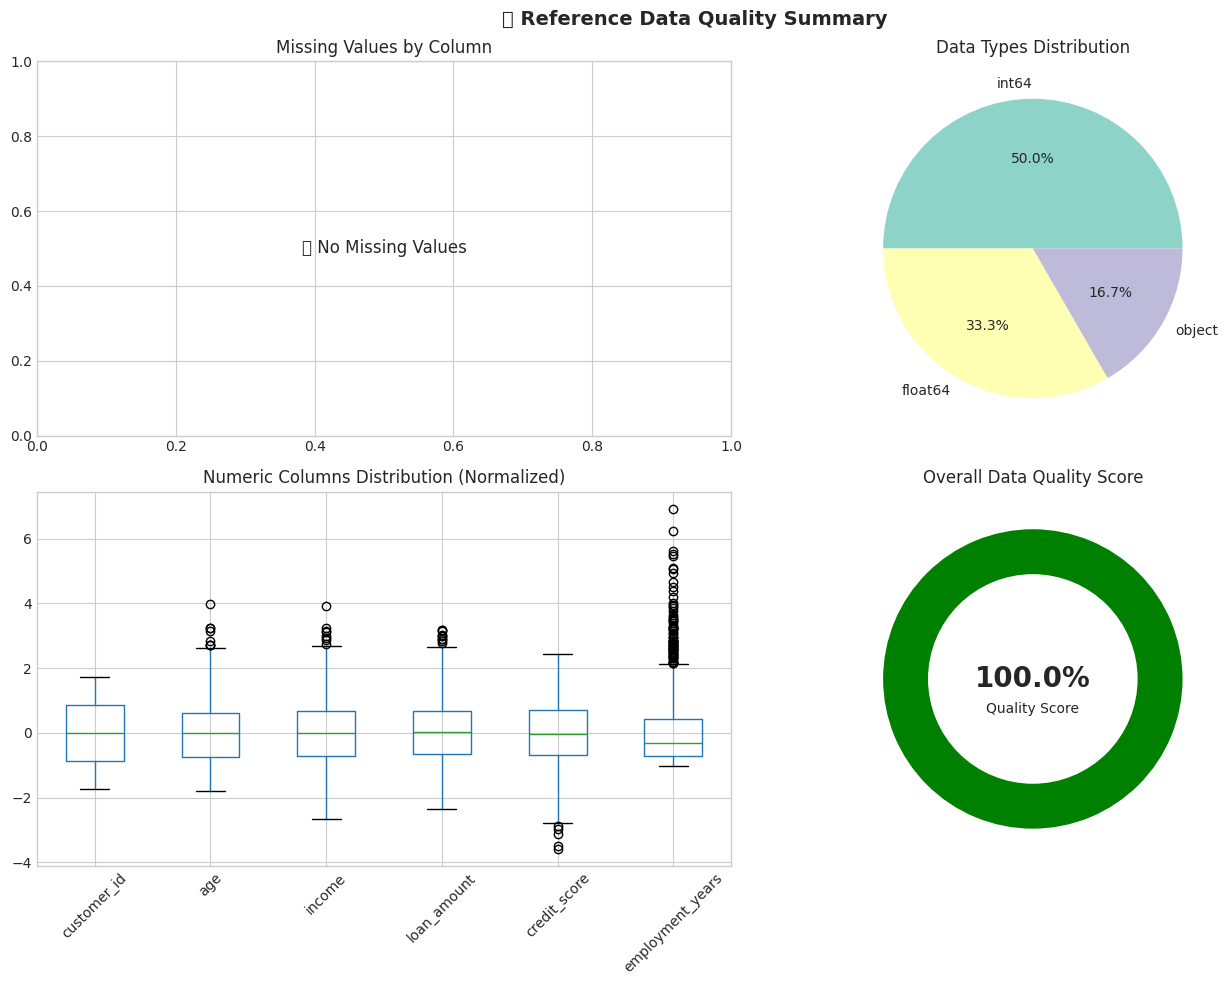

In [12]:
# แสดง visualization สำหรับ Reference Data
print("📊 Reference Data Quality Summary:")
ref_scores = plot_data_quality_summary(reference_data, "Reference Data Quality Summary")

📊 Problematic Data Quality Summary:


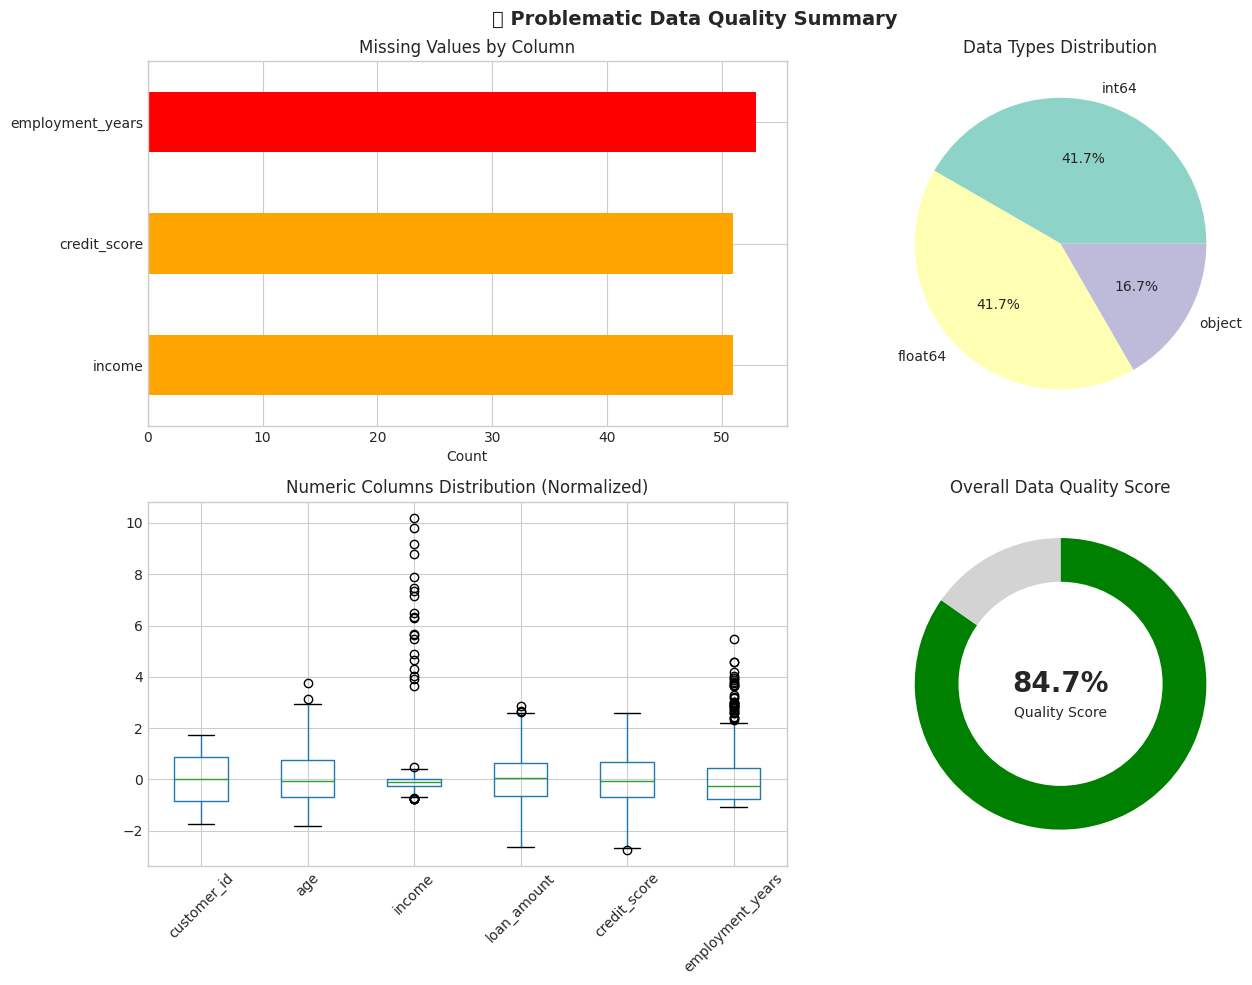

In [13]:
# แสดง visualization สำหรับ Problematic Data
print("📊 Problematic Data Quality Summary:")
problem_scores = plot_data_quality_summary(problematic_data, "Problematic Data Quality Summary")

---
# 📈 Section 2: Model Performance Tracking
## การติดตามประสิทธิภาพโมเดล

ทฤษฎี:

Model Performance Tracking คือการติดตามว่าโมเดลทำนายได้ดีแค่ไหนเมื่อเวลาผ่านไป

Classification Metrics:
- Accuracy - ความถูกต้องโดยรวม
- Precision - ความแม่นยำ (จากที่ทำนาย positive มีกี่ % ที่ถูก)
- Recall - ความครอบคลุม (จาก positive จริง ทำนายถูกกี่ %)
- F1-Score - ค่าเฉลี่ยฮาร์โมนิกของ Precision และ Recall

Regression Metrics:
- MAE (Mean Absolute Error) - ค่าเฉลี่ยความคลาดเคลื่อนสัมบูรณ์
- RMSE (Root Mean Squared Error) - รากของค่าเฉลี่ยความคลาดเคลื่อนกำลังสอง
- R² (R-squared) - สัดส่วนความแปรปรวนที่อธิบายได้

## 2.1 เตรียมข้อมูลและ Train โมเดล

In [14]:
def prepare_features(data, target_col='default'):
    """
    เตรียม features สำหรับ modeling
    
    Parameters:
    -----------
    data : DataFrame - ข้อมูลดิบ
    target_col : str - ชื่อ column ที่เป็น target

    Returns:
    --------
    X : DataFrame - features
    y : Series - target
    """
    df = data.copy()

    # ลบ columns ที่ไม่ใช้
    drop_cols = ['customer_id']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # แยก X และ y
    y = df[target_col]
    X = df.drop(columns=[target_col])

    # Encode categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    # Handle missing values
    X = X.fillna(X.median())

    return X, y

In [15]:
# เตรียมข้อมูล Reference
X_ref, y_ref = prepare_features(reference_data)

# แบ่งข้อมูลสำหรับ train และ test
X_train, X_test, y_train, y_test = train_test_split(
    X_ref, y_ref, test_size=0.3, random_state=42, stratify=y_ref
)

print(f"📊 Training set: {len(X_train)} samples")
print(f"📊 Test set: {len(X_test)} samples")
print(f"\n📋 Features: {list(X_train.columns)}")
print(f"\n📊 Target distribution (train):")
print(y_train.value_counts(normalize=True))

📊 Training set: 1400 samples
📊 Test set: 600 samples

📋 Features: ['age', 'income', 'loan_amount', 'credit_score', 'employment_years', 'num_credit_cards', 'debt_to_income', 'previous_defaults', 'education', 'employment_type']

📊 Target distribution (train):
default
0    0.812143
1    0.187857
Name: proportion, dtype: float64


In [16]:
# Train โมเดล
print("🔧 กำลัง train โมเดล Random Forest...")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

print("✅ Train โมเดลเสร็จสิ้น!")

# ทำนาย
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)
y_prob_test = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n📊 Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"📊 Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

🔧 กำลัง train โมเดล Random Forest...
✅ Train โมเดลเสร็จสิ้น!

📊 Training Accuracy: 0.9986
📊 Test Accuracy: 0.9500


## 2.2 สร้าง Model Performance Monitor Class

In [17]:
class ModelPerformanceMonitor:
    """
    Class สำหรับติดตามประสิทธิภาพโมเดล
    
    รองรับทั้ง Classification และ Regression
    """

    def __init__(self, model, model_name="Model"):
        """
        Parameters:
        -----------
        model : sklearn model - โมเดลที่ train แล้ว
        model_name : str - ชื่อโมเดล
        """
        self.model = model
        self.model_name = model_name
        self.performance_history = []
        self.baseline_metrics = None
        
    def calculate_classification_metrics(self, y_true, y_pred, y_prob=None):
        """คำนวณ metrics สำหรับ classification"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        }
        
        # Confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metrics['true_positive'] = int(tp)
        metrics['true_negative'] = int(tn)
        metrics['false_positive'] = int(fp)
        metrics['false_negative'] = int(fn)
        
        # Specificity
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        return metrics

    def calculate_regression_metrics(self, y_true, y_pred):
        """คำนวณ metrics สำหรับ regression"""
        metrics = {
            'mae': mean_absolute_error(y_true, y_pred),
            'mse': mean_squared_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'r2': r2_score(y_true, y_pred),
            'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
        }
        return metrics

    def set_baseline(self, y_true, y_pred, y_prob=None, task='classification'):
        """ตั้งค่า baseline metrics"""
        if task == 'classification':
            self.baseline_metrics = self.calculate_classification_metrics(y_true, y_pred, y_prob)
        else:
            self.baseline_metrics = self.calculate_regression_metrics(y_true, y_pred)
        
        self.baseline_metrics['timestamp'] = datetime.now()
        self.baseline_metrics['task'] = task
        
        print("✅ ตั้งค่า Baseline Metrics เรียบร้อย:")
        self._print_metrics(self.baseline_metrics)
        
        return self.baseline_metrics

    def evaluate(self, X, y_true, data_name="Current", task='classification'):
        """
        ประเมินประสิทธิภาพโมเดลกับข้อมูลใหม่
        """
        # ทำนาย
        y_pred = self.model.predict(X)
        y_prob = None
        if task == 'classification' and hasattr(self.model, 'predict_proba'):
            y_prob = self.model.predict_proba(X)[:, 1]
        
        # คำนวณ metrics
        if task == 'classification':
            current_metrics = self.calculate_classification_metrics(y_true, y_pred, y_prob)
        else:
            current_metrics = self.calculate_regression_metrics(y_true, y_pred)
        
        current_metrics['timestamp'] = datetime.now()
        current_metrics['data_name'] = data_name
        current_metrics['n_samples'] = len(y_true)
        
        # เก็บประวัติ
        self.performance_history.append(current_metrics)
        
        # เปรียบเทียบกับ baseline
        comparison = self._compare_with_baseline(current_metrics, task)
        
        # แสดงผล
        self._display_evaluation(current_metrics, comparison, data_name, task)
        
        return current_metrics, comparison

    def _compare_with_baseline(self, current_metrics, task):
        """เปรียบเทียบกับ baseline"""
        if self.baseline_metrics is None:
            return None
        
        comparison = {}
        if task == 'classification':
            key_metrics = ['accuracy', 'precision', 'recall', 'f1']
        else:
            key_metrics = ['mae', 'rmse', 'r2']
        
        for metric in key_metrics:
            baseline_val = self.baseline_metrics.get(metric, 0)
            current_val = current_metrics.get(metric, 0)
            
            if task == 'classification':
                # สำหรับ classification ค่าสูงกว่าดีกว่า
                change = current_val - baseline_val
                change_pct = (change / baseline_val * 100) if baseline_val != 0 else 0
            else:
                # สำหรับ regression (MAE, RMSE) ค่าต่ำกว่าดีกว่า (ยกเว้น R2)
                if metric == 'r2':
                    change = current_val - baseline_val
                    change_pct = (change / baseline_val * 100) if baseline_val != 0 else 0
                else:
                    change = baseline_val - current_val
                    change_pct = (change / baseline_val * 100) if baseline_val != 0 else 0
            
            comparison[metric] = {
                'baseline': baseline_val,
                'current': current_val,
                'change': change,
                'change_pct': change_pct,
                'status': 'improved' if change > 0 else 'degraded' if change < 0 else 'stable'
            }
        
        return comparison

    def _print_metrics(self, metrics):
        """แสดง metrics"""
        for key, value in metrics.items():
            if key not in ['timestamp', 'task', 'data_name', 'n_samples']:
                if isinstance(value, float):
                    print(f"   {key}: {value:.4f}")
                else:
                    print(f"   {key}: {value}")

    def _display_evaluation(self, metrics, comparison, data_name, task):
        """แสดงผลการประเมิน"""
        print("=" * 70)
        print(f"📊 MODEL PERFORMANCE EVALUATION: {data_name}")
        print(f"   Model: {self.model_name}")
        print(f"   Samples: {metrics['n_samples']:,}")
        print(f"   Time: {metrics['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print("=" * 70)
        
        if task == 'classification':
            print("\n📈 Classification Metrics:")
            print("-" * 40)
            print(f"   Accuracy:  {metrics['accuracy']:.4f}")
            print(f"   Precision: {metrics['precision']:.4f}")
            print(f"   Recall:    {metrics['recall']:.4f}")
            print(f"   F1-Score:  {metrics['f1']:.4f}")
            print(f"\n📊 Confusion Matrix:")
            print(f"   TP: {metrics['true_positive']} | FP: {metrics['false_positive']}")
            print(f"   FN: {metrics['false_negative']} | TN: {metrics['true_negative']}")
        else:
            print("\n📈 Regression Metrics:")
            print("-" * 40)
            print(f"   MAE:  {metrics['mae']:.4f}")
            print(f"   RMSE: {metrics['rmse']:.4f}")
            print(f"   R²:   {metrics['r2']:.4f}")
        
        if comparison:
            print("\n📊 Comparison with Baseline:")
            print("-" * 40)
            for metric, values in comparison.items():
                icon = "📈" if values['status'] == 'improved' else "📉" if values['status'] == 'degraded' else "➡️"
                print(f"   {icon} {metric}: {values['baseline']:.4f} → {values['current']:.4f} ({values['change_pct']:+.2f}%)")
        
        print("=" * 70)

In [18]:
# สร้าง Performance Monitor
perf_monitor = ModelPerformanceMonitor(rf_model, "Random Forest Credit Risk")

# ตั้งค่า Baseline ด้วย Test Data
print("📊 ตั้งค่า Baseline Metrics:")
baseline = perf_monitor.set_baseline(y_test, y_pred_test, y_prob_test, task='classification')

📊 ตั้งค่า Baseline Metrics:
✅ ตั้งค่า Baseline Metrics เรียบร้อย:
   accuracy: 0.9500
   precision: 0.9490
   recall: 0.9500
   f1: 0.9489
   true_positive: 91
   true_negative: 479
   false_positive: 9
   false_negative: 21
   specificity: 0.9816


In [19]:
# ประเมินกับ Current Data (ข้อมูลใหม่ที่มี drift)
X_curr, y_curr = prepare_features(current_data)
X_curr_scaled = scaler.transform(X_curr)

print("\n📊 ประเมินกับ Current Data (มี Drift):")
curr_metrics, comparison = perf_monitor.evaluate(
    X_curr_scaled, y_curr,
    data_name="Current Data (with drift)",
    task='classification'
)


📊 ประเมินกับ Current Data (มี Drift):
📊 MODEL PERFORMANCE EVALUATION: Current Data (with drift)
   Model: Random Forest Credit Risk
   Samples: 1,000
   Time: 2026-01-07 04:01:50

📈 Classification Metrics:
----------------------------------------
   Accuracy:  0.9630
   Precision: 0.9620
   Recall:    0.9630
   F1-Score:  0.9617

📊 Confusion Matrix:
   TP: 97 | FP: 9
   FN: 28 | TN: 866

📊 Comparison with Baseline:
----------------------------------------
   📈 accuracy: 0.9500 → 0.9630 (+1.37%)
   📈 precision: 0.9490 → 0.9620 (+1.36%)
   📈 recall: 0.9500 → 0.9630 (+1.37%)
   📈 f1: 0.9489 → 0.9617 (+1.35%)


## 2.3 จำลองการ Monitor หลายช่วงเวลา

In [20]:
def simulate_time_series_monitoring(model, scaler, n_periods=10):
    """
    จำลองการ monitor โมเดลข้ามหลายช่วงเวลา
    """
    performance_over_time = []

    for period in range(n_periods):
        # สร้างข้อมูลจำลองแต่ละช่วงเวลา โดย drift เพิ่มขึ้นเรื่อยๆ
        drift_level = period * 0.05  # drift เพิ่มขึ้น 5% ต่อ period
        
        period_data = create_credit_data(
            n_samples=500, 
            seed=42 + period,
            drift_level=drift_level
        )
        
        X_period, y_period = prepare_features(period_data)
        X_period_scaled = scaler.transform(X_period)
        
        # ทำนาย
        y_pred_period = model.predict(X_period_scaled)
        
        # คำนวณ metrics
        metrics = {
            'period': period + 1,
            'drift_level': drift_level,
            'accuracy': accuracy_score(y_period, y_pred_period),
            'precision': precision_score(y_period, y_pred_period, average='weighted', zero_division=0),
            'recall': recall_score(y_period, y_pred_period, average='weighted', zero_division=0),
            'f1': f1_score(y_period, y_pred_period, average='weighted', zero_division=0),
            'n_samples': len(y_period),
            'default_rate': y_period.mean()
        }
        
        performance_over_time.append(metrics)

    return pd.DataFrame(performance_over_time)

In [21]:
# จำลองการ monitor 10 ช่วงเวลา
print("🔄 จำลองการ Monitor ข้ามหลายช่วงเวลา...")
time_series_perf = simulate_time_series_monitoring(rf_model, scaler, n_periods=10)

print("\n📊 Performance Over Time:")
print(time_series_perf.to_string(index=False))

🔄 จำลองการ Monitor ข้ามหลายช่วงเวลา...

📊 Performance Over Time:
 period  drift_level  accuracy  precision  recall       f1  n_samples  default_rate
      1         0.00     0.964   0.963705   0.964 0.963826        500         0.168
      2         0.05     0.940   0.940575   0.940 0.940264        500         0.176
      3         0.10     0.932   0.929794   0.932 0.929630        500         0.176
      4         0.15     0.956   0.955646   0.956 0.954442        500         0.174
      5         0.20     0.954   0.954223   0.954 0.954105        500         0.172
      6         0.25     0.950   0.948584   0.950 0.949091        500         0.124
      7         0.30     0.950   0.948288   0.950 0.948184        500         0.140
      8         0.35     0.968   0.967433   0.968 0.967589        500         0.136
      9         0.40     0.950   0.948212   0.950 0.948702        500         0.124
     10         0.45     0.948   0.945662   0.948 0.945038        500         0.122


## 2.4 Visualization: Performance Over Time

In [22]:
def plot_performance_over_time(perf_df):
    """
    แสดงกราฟประสิทธิภาพโมเดลตามเวลา
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('📈 Model Performance Over Time', fontsize=14, fontweight='bold')

    # 1. Main Metrics Over Time
    ax1 = axes[0, 0]
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metrics_to_plot:
        ax1.plot(perf_df['period'], perf_df[metric], marker='o', label=metric.capitalize())
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Score')
    ax1.set_title('Classification Metrics Over Time')
    ax1.legend()
    ax1.set_ylim([0.5, 1.0])
    ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Threshold')
    ax1.grid(True, alpha=0.3)

    # 2. Accuracy vs Drift Level
    ax2 = axes[0, 1]
    ax2.scatter(perf_df['drift_level'], perf_df['accuracy'], s=100, c=perf_df['period'], cmap='viridis')
    ax2.plot(perf_df['drift_level'], perf_df['accuracy'], 'r--', alpha=0.5)
    ax2.set_xlabel('Drift Level')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Data Drift Level')

    # เพิ่ม colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=len(perf_df)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2)
    cbar.set_label('Period')

    # 3. Default Rate Over Time
    ax3 = axes[1, 0]
    ax3.bar(perf_df['period'], perf_df['default_rate'], color='coral', alpha=0.7)
    ax3.set_xlabel('Time Period')
    ax3.set_ylabel('Default Rate')
    ax3.set_title('Target (Default Rate) Over Time')
    ax3.axhline(y=perf_df['default_rate'].iloc[0], color='green', linestyle='--', 
                label=f"Baseline: {perf_df['default_rate'].iloc[0]:.2%}")
    ax3.legend()

    # 4. Performance Degradation Alert
    ax4 = axes[1, 1]

    # คำนวณ degradation จาก baseline
    baseline_accuracy = perf_df['accuracy'].iloc[0]
    degradation = (baseline_accuracy - perf_df['accuracy']) / baseline_accuracy * 100

    colors = ['green' if d < 5 else 'orange' if d < 10 else 'red' for d in degradation]
    ax4.bar(perf_df['period'], degradation, color=colors, alpha=0.7)
    ax4.set_xlabel('Time Period')
    ax4.set_ylabel('Degradation (%)')
    ax4.set_title('Accuracy Degradation from Baseline')
    ax4.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Warning (5%)')
    ax4.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Critical (10%)')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # สรุปผล
    print("\n📊 Performance Summary:")
    print(f"   Baseline Accuracy: {baseline_accuracy:.4f}")
    print(f"   Final Accuracy: {perf_df['accuracy'].iloc[-1]:.4f}")
    print(f"   Total Degradation: {degradation.iloc[-1]:.2f}%")

    if degradation.iloc[-1] > 10:
        print("   🔴 Status: CRITICAL - ต้อง retrain โมเดล!")
    elif degradation.iloc[-1] > 5:
        print("   🟡 Status: WARNING - ควรตรวจสอบและเตรียม retrain")
    else:
        print("   🟢 Status: HEALTHY - โมเดลทำงานปกติ")

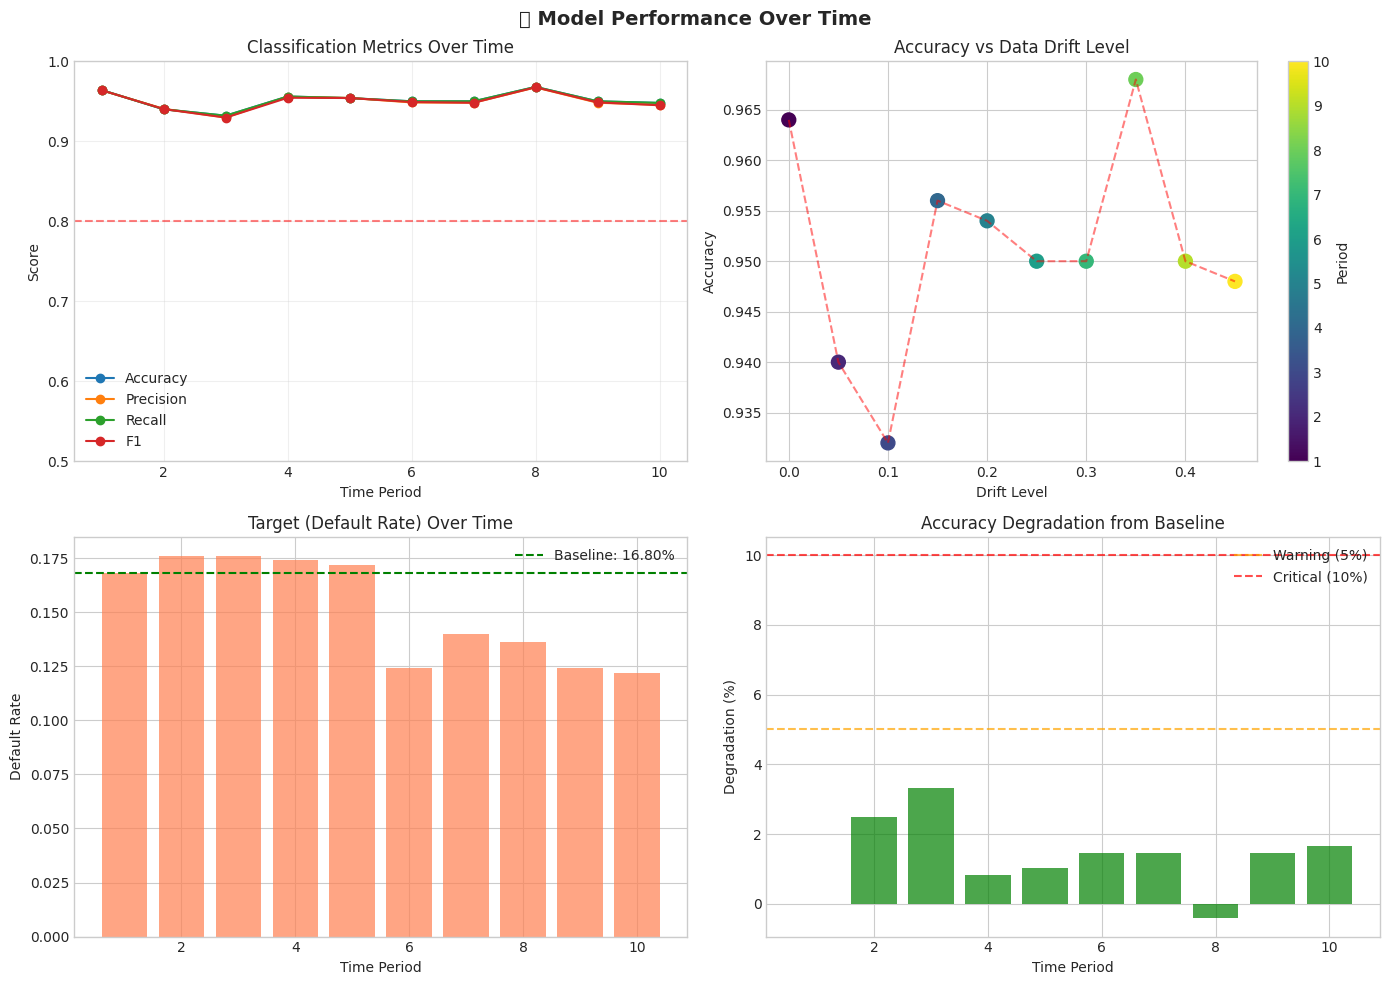


📊 Performance Summary:
   Baseline Accuracy: 0.9640
   Final Accuracy: 0.9480
   Total Degradation: 1.66%
   🟢 Status: HEALTHY - โมเดลทำงานปกติ


In [23]:
# แสดงกราฟ
plot_performance_over_time(time_series_perf)

## 2.5 Confusion Matrix Visualization

In [24]:
def plot_confusion_matrix_comparison(y_true_baseline, y_pred_baseline,
                                      y_true_current, y_pred_current):
    """
    เปรียบเทียบ Confusion Matrix ระหว่าง Baseline และ Current
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('📊 Confusion Matrix Comparison', fontsize=14, fontweight='bold')

    # Baseline
    cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline)
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    axes[0].set_title('Baseline (Test Data)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Current
    cm_current = confusion_matrix(y_true_current, y_pred_current)
    sns.heatmap(cm_current, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    axes[1].set_title('Current Data (with Drift)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

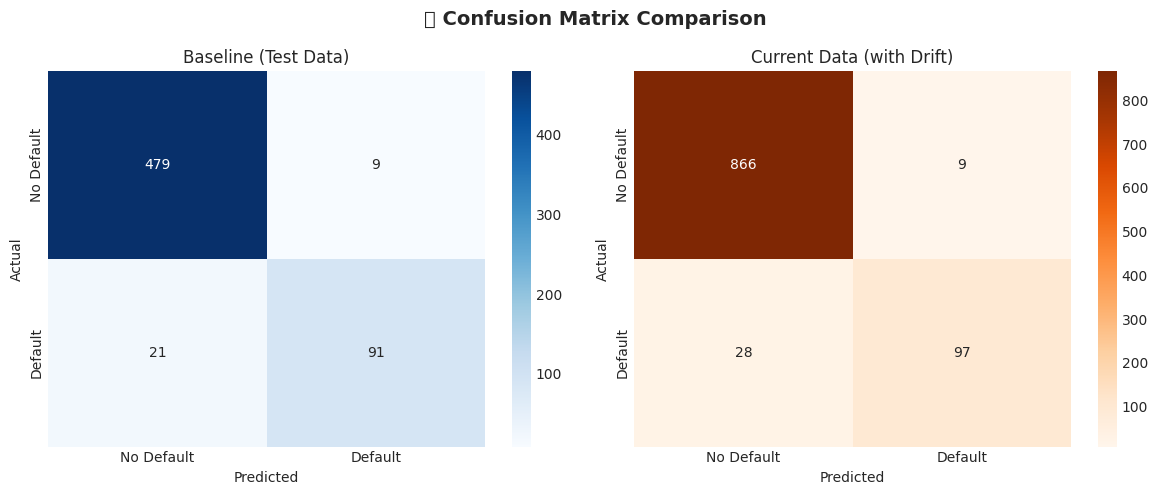

In [25]:
# ทำนาย current data
y_pred_curr = rf_model.predict(X_curr_scaled)

# แสดง confusion matrix comparison
plot_confusion_matrix_comparison(y_test, y_pred_test, y_curr, y_pred_curr)

---
# 🎯 Section 3: Target Drift Detection
## การตรวจจับการเปลี่ยนแปลงของ Target Distribution

ทฤษฎี:

Target Drift (หรือ Concept Drift) คือการเปลี่ยนแปลงของ distribution ของ target variable

ประเภทของ Drift:
1. Sudden Drift - เปลี่ยนแปลงอย่างกะทันหัน
2. Gradual Drift - เปลี่ยนแปลงทีละน้อย
3. Recurring Drift - เปลี่ยนแปลงเป็นรอบ (เช่น seasonal)

วิธีการตรวจจับ:
1. Statistical Tests - Chi-square, KS test, PSI
2. Distribution Comparison - เปรียบเทียบ histogram
3. Threshold-based Alerts - แจ้งเตือนเมื่อเกินค่าที่กำหนด

## 3.1 สร้าง Drift Detection Class

In [26]:
class DriftDetector:
    """
    Class สำหรับตรวจจับ Data Drift และ Target Drift
    
    รองรับหลายวิธีการทางสถิติ:
    - Kolmogorov-Smirnov Test (สำหรับ continuous)
    - Chi-Square Test (สำหรับ categorical)
    - Population Stability Index (PSI)
    - Wasserstein Distance
    """

    def __init__(self, reference_data, reference_name="Reference"):
        """
        Parameters:
        -----------
        reference_data : DataFrame - ข้อมูล reference
        reference_name : str - ชื่อข้อมูล reference
        """
        self.reference_data = reference_data.copy()
        self.reference_name = reference_name
        self.drift_results = {}
        
    def ks_test(self, reference_col, current_col):
        """
        Kolmogorov-Smirnov Test สำหรับ continuous variables
        
        H0: ทั้งสอง distribution มาจากประชากรเดียวกัน
        ถ้า p-value < 0.05 แสดงว่ามี drift
        """
        statistic, p_value = ks_2samp(reference_col.dropna(), current_col.dropna())
        return {
            'test': 'Kolmogorov-Smirnov',
            'statistic': statistic,
            'p_value': p_value,
            'drift_detected': p_value < 0.05
        }

    def chi_square_test(self, reference_col, current_col):
        """
        Chi-Square Test สำหรับ categorical variables
        """
        # สร้าง contingency table
        ref_counts = reference_col.value_counts()
        curr_counts = current_col.value_counts()
        
        # รวม categories
        all_categories = set(ref_counts.index) | set(curr_counts.index)
        
        ref_freq = [ref_counts.get(cat, 0) for cat in all_categories]
        curr_freq = [curr_counts.get(cat, 0) for cat in all_categories]
        
        contingency = np.array([ref_freq, curr_freq])
        
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        return {
            'test': 'Chi-Square',
            'statistic': chi2,
            'p_value': p_value,
            'degrees_of_freedom': dof,
            'drift_detected': p_value < 0.05
        }

    def calculate_psi(self, reference_col, current_col, bins=10):
        """
        Population Stability Index (PSI)
        
        PSI < 0.1: ไม่มี drift
        0.1 <= PSI < 0.25: drift เล็กน้อย
        PSI >= 0.25: drift มาก
        """
        # สร้าง bins จาก reference
        ref_min, ref_max = reference_col.min(), reference_col.max()
        bin_edges = np.linspace(ref_min, ref_max, bins + 1)
        
        # คำนวณ % ในแต่ละ bin
        ref_hist, _ = np.histogram(reference_col, bins=bin_edges)
        curr_hist, _ = np.histogram(current_col.clip(ref_min, ref_max), bins=bin_edges)
        
        # แปลงเป็น percentage
        ref_pct = ref_hist / len(reference_col)
        curr_pct = curr_hist / len(current_col)
        
        # หลีกเลี่ยง log(0)
        ref_pct = np.where(ref_pct == 0, 0.0001, ref_pct)
        curr_pct = np.where(curr_pct == 0, 0.0001, curr_pct)
        
        # คำนวณ PSI
        psi = np.sum((curr_pct - ref_pct) * np.log(curr_pct / ref_pct))
        
        return {
            'psi': psi,
            'interpretation': 'No Drift' if psi < 0.1 else 'Slight Drift' if psi < 0.25 else 'Significant Drift',
            'drift_detected': psi >= 0.1
        }

    def wasserstein_distance_test(self, reference_col, current_col):
        """
        Wasserstein Distance (Earth Mover's Distance)
        วัดระยะห่างระหว่างสอง distributions
        """
        distance = wasserstein_distance(reference_col.dropna(), current_col.dropna())
        
        # Normalize by reference std
        ref_std = reference_col.std()
        normalized_distance = distance / ref_std if ref_std > 0 else distance
        
        return {
            'distance': distance,
            'normalized_distance': normalized_distance,
            'drift_detected': normalized_distance > 0.1
        }

    def detect_feature_drift(self, current_data, columns=None):
        """
        ตรวจจับ drift สำหรับทุก features
        """
        if columns is None:
            # ใช้ทุก columns ที่มีทั้งสอง datasets
            columns = [col for col in self.reference_data.columns if col in current_data.columns]
        
        results = []
        
        for col in columns:
            ref_col = self.reference_data[col]
            curr_col = current_data[col]
            
            # เลือกวิธีทดสอบตามประเภทข้อมูล
            if ref_col.dtype in ['object', 'category'] or ref_col.nunique() < 10:
                # Categorical
                test_result = self.chi_square_test(ref_col, curr_col)
                test_type = 'categorical'
            else:
                # Continuous
                ks_result = self.ks_test(ref_col, curr_col)
                psi_result = self.calculate_psi(ref_col, curr_col)
                
                test_result = {
                    'test': 'KS + PSI',
                    'ks_statistic': ks_result['statistic'],
                    'ks_p_value': ks_result['p_value'],
                    'psi': psi_result['psi'],
                    'psi_interpretation': psi_result['interpretation'],
                    'drift_detected': ks_result['drift_detected'] or psi_result['drift_detected']
                }
                test_type = 'continuous'
            
            results.append({
                'column': col,
                'type': test_type,
                **test_result
            })
        
        self.drift_results['feature_drift'] = results
        return pd.DataFrame(results)

    def detect_target_drift(self, current_data, target_col):
        """
        ตรวจจับ Target Drift โดยเฉพาะ
        """
        ref_target = self.reference_data[target_col]
        curr_target = current_data[target_col]
        
        result = {
            'column': target_col,
            'reference_mean': ref_target.mean(),
            'current_mean': curr_target.mean(),
            'reference_std': ref_target.std(),
            'current_std': curr_target.std()
        }
        
        # ทดสอบทางสถิติ
        if ref_target.nunique() <= 2:  # Binary target
            # Chi-square test
            chi_result = self.chi_square_test(ref_target, curr_target)
            result.update({
                'test': 'Chi-Square',
                'statistic': chi_result['statistic'],
                'p_value': chi_result['p_value'],
                'drift_detected': chi_result['drift_detected']
            })
        else:
            # KS test + PSI
            ks_result = self.ks_test(ref_target, curr_target)
            psi_result = self.calculate_psi(ref_target, curr_target)
            result.update({
                'test': 'KS + PSI',
                'ks_statistic': ks_result['statistic'],
                'ks_p_value': ks_result['p_value'],
                'psi': psi_result['psi'],
                'drift_detected': ks_result['drift_detected'] or psi_result['drift_detected']
            })
        
        self.drift_results['target_drift'] = result
        return result

    def generate_drift_report(self, current_data, target_col=None):
        """
        สร้าง Drift Report ฉบับเต็ม
        """
        print("=" * 70)
        print("🔍 DRIFT DETECTION REPORT")
        print("=" * 70)
        print(f"📅 Generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Reference Data: {len(self.reference_data):,} samples")
        print(f"📊 Current Data: {len(current_data):,} samples")
        print()
        
        # Feature Drift
        print("-" * 50)
        print("1️⃣ FEATURE DRIFT DETECTION")
        print("-" * 50)
        
        feature_cols = [col for col in self.reference_data.columns 
                       if col != target_col and col in current_data.columns]
        feature_drift_df = self.detect_feature_drift(current_data, feature_cols)
        
        drifted_features = feature_drift_df[feature_drift_df['drift_detected'] == True]
        
        if len(drifted_features) > 0:
            print(f"⚠️ พบ Drift ใน {len(drifted_features)}/{len(feature_cols)} features:")
            for _, row in drifted_features.iterrows():
                print(f"   🔴 {row['column']}: {row['test']}")
        else:
            print("✅ ไม่พบ Feature Drift ที่มีนัยสำคัญ")
        print()
        
        # Target Drift
        if target_col:
            print("-" * 50)
            print("2️⃣ TARGET DRIFT DETECTION")
            print("-" * 50)
            
            target_result = self.detect_target_drift(current_data, target_col)
            
            print(f"   Target Column: {target_col}")
            print(f"   Reference Mean: {target_result['reference_mean']:.4f}")
            print(f"   Current Mean: {target_result['current_mean']:.4f}")
            print(f"   Change: {(target_result['current_mean'] - target_result['reference_mean']):.4f}")
            print(f"   Test: {target_result['test']}")
            print(f"   P-value: {target_result.get('p_value', 'N/A')}")
            
            if target_result['drift_detected']:
                print("   🔴 Status: TARGET DRIFT DETECTED!")
            else:
                print("   🟢 Status: No significant target drift")
        
        print()
        print("=" * 70)
        print("📊 END OF DRIFT REPORT")
        print("=" * 70)
        
        return {
            'feature_drift': feature_drift_df,
            'target_drift': self.drift_results.get('target_drift')
        }

In [27]:
# ทดสอบ Drift Detection
print("🔍 ตรวจจับ Drift ระหว่าง Reference และ Current Data:")
print()

drift_detector = DriftDetector(reference_data, "Reference Data")
drift_report = drift_detector.generate_drift_report(current_data, target_col='default')

🔍 ตรวจจับ Drift ระหว่าง Reference และ Current Data:

🔍 DRIFT DETECTION REPORT
📅 Generated at: 2026-01-07 04:01:51
📊 Reference Data: 2,000 samples
📊 Current Data: 1,000 samples

--------------------------------------------------
1️⃣ FEATURE DRIFT DETECTION
--------------------------------------------------
⚠️ พบ Drift ใน 4/11 features:
   🔴 customer_id: KS + PSI
   🔴 income: KS + PSI
   🔴 loan_amount: KS + PSI
   🔴 debt_to_income: KS + PSI

--------------------------------------------------
2️⃣ TARGET DRIFT DETECTION
--------------------------------------------------
   Target Column: default
   Reference Mean: 0.1875
   Current Mean: 0.1250
   Change: -0.0625
   Test: Chi-Square
   P-value: 1.8843990219224396e-05
   🔴 Status: TARGET DRIFT DETECTED!

📊 END OF DRIFT REPORT


## 3.2 Visualization: Drift Analysis

In [28]:
def plot_drift_analysis(reference_data, current_data, columns_to_plot=None, target_col='default'):
    """
    Visualization สำหรับ Drift Analysis
    """
    if columns_to_plot is None:
        numeric_cols = reference_data.select_dtypes(include=[np.number]).columns
        columns_to_plot = [col for col in numeric_cols if col != target_col][:6]

    n_cols = min(len(columns_to_plot), 3)
    n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle('📊 Feature Distribution Comparison: Reference vs Current', 
                 fontsize=14, fontweight='bold')

    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for idx, col in enumerate(columns_to_plot):
        ax = axes[idx] if isinstance(axes, (list, np.ndarray)) else axes
        
        # Plot distributions
        ax.hist(reference_data[col], bins=30, alpha=0.5, label='Reference', color='blue', density=True)
        ax.hist(current_data[col], bins=30, alpha=0.5, label='Current', color='orange', density=True)
        
        # KS test
        ks_stat, ks_pval = ks_2samp(reference_data[col].dropna(), current_data[col].dropna())
        
        ax.set_title(f'{col}\nKS stat: {ks_stat:.3f}, p-value: {ks_pval:.3f}')
        ax.legend()
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        
        # เพิ่มสี background ตาม drift status
        if ks_pval < 0.05:
            ax.set_facecolor('#ffcccc')  # สีแดงอ่อนถ้ามี drift

    # ซ่อน axes ที่ไม่ใช้
    for idx in range(len(columns_to_plot), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

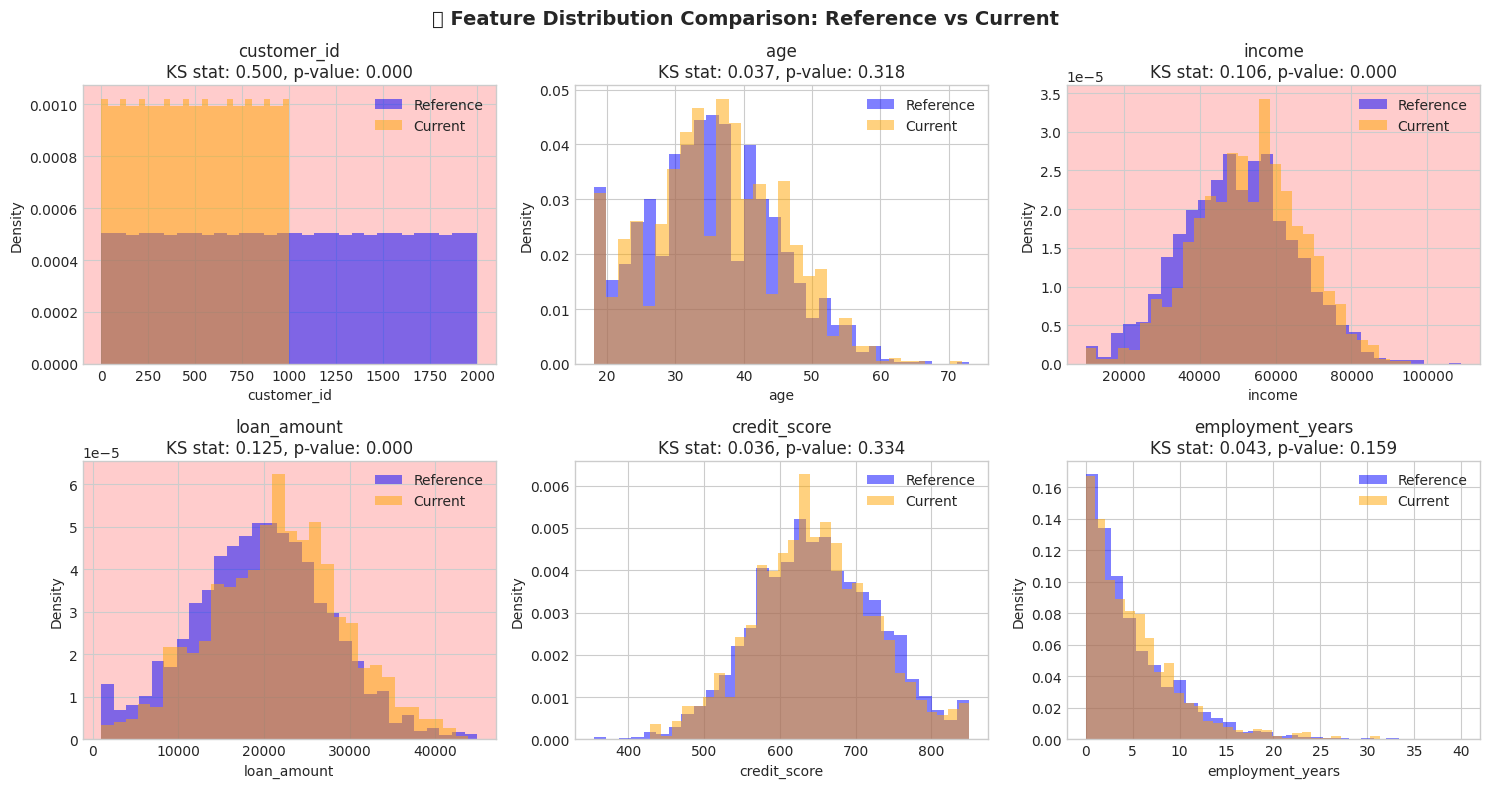

In [29]:
# แสดง Feature Distribution Comparison
plot_drift_analysis(reference_data, current_data, target_col='default')

In [30]:
def plot_target_drift(reference_data, current_data, target_col='default'):
    """
    Visualization สำหรับ Target Drift
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('🎯 Target Drift Analysis', fontsize=14, fontweight='bold')

    # 1. Distribution Comparison
    ax1 = axes[0]
    ref_counts = reference_data[target_col].value_counts(normalize=True)
    curr_counts = current_data[target_col].value_counts(normalize=True)

    x = np.arange(len(ref_counts))
    width = 0.35

    ax1.bar(x - width/2, ref_counts.values, width, label='Reference', color='blue', alpha=0.7)
    ax1.bar(x + width/2, curr_counts.values, width, label='Current', color='orange', alpha=0.7)

    ax1.set_xlabel('Target Value')
    ax1.set_ylabel('Proportion')
    ax1.set_title('Target Distribution Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['No Default (0)', 'Default (1)'])
    ax1.legend()

    # เพิ่ม % labels
    for i, (ref_v, curr_v) in enumerate(zip(ref_counts.values, curr_counts.values)):
        ax1.text(i - width/2, ref_v + 0.01, f'{ref_v:.1%}', ha='center', fontsize=9)
        ax1.text(i + width/2, curr_v + 0.01, f'{curr_v:.1%}', ha='center', fontsize=9)

    # 2. Cumulative Distribution
    ax2 = axes[1]
    ref_sorted = np.sort(reference_data[target_col])
    curr_sorted = np.sort(current_data[target_col])

    ref_cdf = np.arange(1, len(ref_sorted) + 1) / len(ref_sorted)
    curr_cdf = np.arange(1, len(curr_sorted) + 1) / len(curr_sorted)

    ax2.plot(ref_sorted, ref_cdf, label='Reference', color='blue')
    ax2.plot(curr_sorted, curr_cdf, label='Current', color='orange')
    ax2.set_xlabel('Target Value')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function (CDF)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Drift Summary
    ax3 = axes[2]
    ax3.axis('off')

    # คำนวณ metrics
    ref_mean = reference_data[target_col].mean()
    curr_mean = current_data[target_col].mean()
    change = curr_mean - ref_mean
    change_pct = (change / ref_mean) * 100 if ref_mean != 0 else 0

    # Chi-square test
    contingency = np.array([
        [reference_data[target_col].sum(), len(reference_data) - reference_data[target_col].sum()],
        [current_data[target_col].sum(), len(current_data) - current_data[target_col].sum()]
    ])
    chi2, p_value, _, _ = chi2_contingency(contingency)

    summary_text = f"""
📊 TARGET DRIFT SUMMARY
─────────────────────────────

Reference Default Rate: {ref_mean:.2%}
Current Default Rate:   {curr_mean:.2%}

Absolute Change: {change:+.2%}
Relative Change: {change_pct:+.1f}%

─────────────────────────────
Statistical Test (Chi-Square):
Chi² Statistic: {chi2:.4f}
P-value: {p_value:.4f}

─────────────────────────────
Status: {'🔴 DRIFT DETECTED' if p_value < 0.05 else '🟢 NO SIGNIFICANT DRIFT'}
"""

    ax3.text(0.1, 0.5, summary_text, transform=ax3.transAxes, 
             fontsize=11, verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

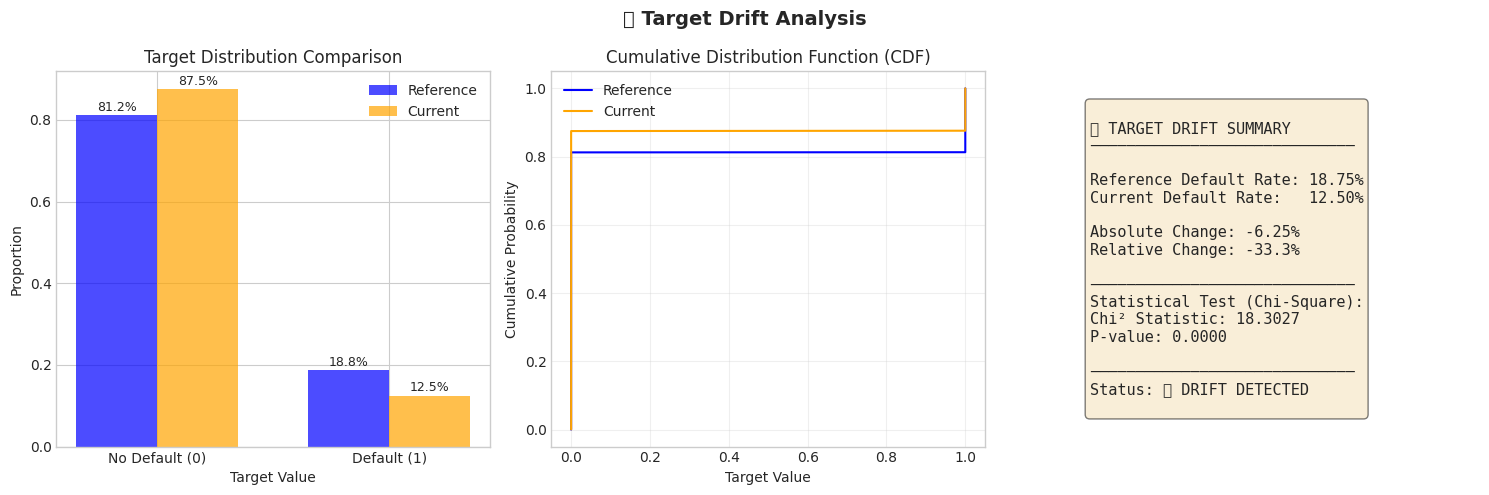

In [31]:
# แสดง Target Drift Analysis
plot_target_drift(reference_data, current_data, target_col='default')

## 3.3 Prediction Drift Detection

In [32]:
def detect_prediction_drift(model, scaler, reference_data, current_data, target_col='default'):
    """
    ตรวจจับ Prediction Drift
    เปรียบเทียบการกระจายของ predictions ระหว่าง reference และ current
    """
    # เตรียมข้อมูล
    X_ref, _ = prepare_features(reference_data, target_col)
    X_curr, _ = prepare_features(current_data, target_col)

    X_ref_scaled = scaler.transform(X_ref)
    X_curr_scaled = scaler.transform(X_curr)

    # ทำนาย probability
    ref_proba = model.predict_proba(X_ref_scaled)[:, 1]
    curr_proba = model.predict_proba(X_curr_scaled)[:, 1]

    # ทำนาย class
    ref_pred = model.predict(X_ref_scaled)
    curr_pred = model.predict(X_curr_scaled)

    # Statistical tests
    ks_stat, ks_pval = ks_2samp(ref_proba, curr_proba)
    wasserstein = wasserstein_distance(ref_proba, curr_proba)

    # Prediction distribution
    ref_positive_rate = ref_pred.mean()
    curr_positive_rate = curr_pred.mean()

    print("=" * 70)
    print("🔮 PREDICTION DRIFT ANALYSIS")
    print("=" * 70)
    print()
    print("📊 Prediction Probability Statistics:")
    print(f"   Reference - Mean: {ref_proba.mean():.4f}, Std: {ref_proba.std():.4f}")
    print(f"   Current   - Mean: {curr_proba.mean():.4f}, Std: {curr_proba.std():.4f}")
    print()
    print("📊 Predicted Positive Rate:")
    print(f"   Reference: {ref_positive_rate:.2%}")
    print(f"   Current:   {curr_positive_rate:.2%}")
    print(f"   Change:    {(curr_positive_rate - ref_positive_rate):.2%}")
    print()
    print("📊 Statistical Tests:")
    print(f"   KS Statistic: {ks_stat:.4f}")
    print(f"   KS P-value: {ks_pval:.4f}")
    print(f"   Wasserstein Distance: {wasserstein:.4f}")
    print()

    if ks_pval < 0.05:
        print("   🔴 Status: PREDICTION DRIFT DETECTED!")
    else:
        print("   🟢 Status: No significant prediction drift")

    print("=" * 70)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('🔮 Prediction Drift Analysis', fontsize=14, fontweight='bold')

    # 1. Probability Distribution
    ax1 = axes[0]
    ax1.hist(ref_proba, bins=50, alpha=0.5, label='Reference', color='blue', density=True)
    ax1.hist(curr_proba, bins=50, alpha=0.5, label='Current', color='orange', density=True)
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Prediction Probability Distribution\nKS stat: {ks_stat:.3f}, p-value: {ks_pval:.4f}')
    ax1.legend()
    ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')

    # 2. Predicted Class Distribution
    ax2 = axes[1]
    categories = ['No Default', 'Default']
    ref_dist = [(ref_pred == 0).sum(), (ref_pred == 1).sum()]
    curr_dist = [(curr_pred == 0).sum(), (curr_pred == 1).sum()]

    x = np.arange(len(categories))
    width = 0.35

    ax2.bar(x - width/2, ref_dist, width, label='Reference', color='blue', alpha=0.7)
    ax2.bar(x + width/2, curr_dist, width, label='Current', color='orange', alpha=0.7)
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Count')
    ax2.set_title('Predicted Class Distribution')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return {
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pval,
        'wasserstein_distance': wasserstein,
        'ref_positive_rate': ref_positive_rate,
        'curr_positive_rate': curr_positive_rate,
        'drift_detected': ks_pval < 0.05
    }

🔮 PREDICTION DRIFT ANALYSIS

📊 Prediction Probability Statistics:
   Reference - Mean: 0.1844, Std: 0.3329
   Current   - Mean: 0.1262, Std: 0.2622

📊 Predicted Positive Rate:
   Reference: 18.05%
   Current:   10.60%
   Change:    -7.45%

📊 Statistical Tests:
   KS Statistic: 0.0860
   KS P-value: 0.0001
   Wasserstein Distance: 0.0612

   🔴 Status: PREDICTION DRIFT DETECTED!


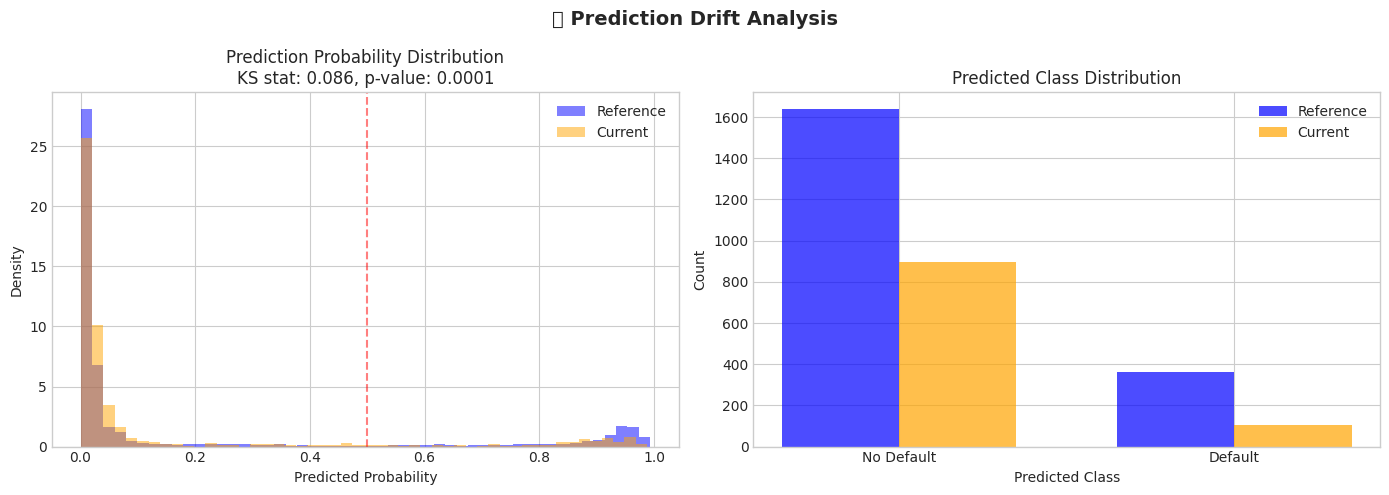

In [33]:
# ตรวจจับ Prediction Drift
prediction_drift = detect_prediction_drift(rf_model, scaler, reference_data, current_data)

## 3.4 Drift Alert System

In [34]:
class DriftAlertSystem:
    """
    ระบบแจ้งเตือน Drift
    """

    def __init__(self):
        self.thresholds = {
            'psi': 0.1,              # PSI threshold
            'ks_pvalue': 0.05,       # KS test p-value
            'target_change': 0.05,   # Target rate change
            'prediction_change': 0.05  # Prediction rate change
        }
        self.alerts = []

    def check_drift_alerts(self, drift_results, data_name="Current Data"):
        """
        ตรวจสอบและสร้าง alerts จากผลการตรวจจับ drift
        """
        self.alerts = []
        
        # Check feature drift
        if 'feature_drift' in drift_results:
            feature_df = drift_results['feature_drift']
            drifted_features = feature_df[feature_df['drift_detected'] == True]
            
            if len(drifted_features) > 0:
                drift_pct = len(drifted_features) / len(feature_df) * 100
                alert_type = 'CRITICAL' if drift_pct > 30 else 'WARNING'
                
                self.alerts.append({
                    'type': alert_type,
                    'category': 'Feature Drift',
                    'message': f"พบ {len(drifted_features)} features ({drift_pct:.1f}%) มี drift",
                    'details': drifted_features['column'].tolist()
                })
        
        # Check target drift
        if 'target_drift' in drift_results and drift_results['target_drift']:
            target_result = drift_results['target_drift']
            if target_result.get('drift_detected', False):
                change = abs(target_result['current_mean'] - target_result['reference_mean'])
                
                self.alerts.append({
                    'type': 'CRITICAL' if change > 0.1 else 'WARNING',
                    'category': 'Target Drift',
                    'message': f"Target distribution เปลี่ยนแปลง (change: {change:.2%})",
                    'details': target_result
                })
        
        # Display alerts
        self._display_alerts(data_name)
        
        return self.alerts

    def _display_alerts(self, data_name):
        """แสดงผล alerts"""
        print("=" * 70)
        print(f"🚨 DRIFT ALERTS: {data_name}")
        print("=" * 70)
        
        if not self.alerts:
            print("✅ ไม่มี drift alerts - ข้อมูลยังคงมีลักษณะใกล้เคียงกับ reference")
        else:
            print(f"⚠️ พบ {len(self.alerts)} alerts:")
            print()
            
            for i, alert in enumerate(self.alerts, 1):
                icon = "🔴" if alert['type'] == 'CRITICAL' else "🟡"
                print(f"{icon} Alert #{i}: [{alert['type']}] {alert['category']}")
                print(f"   Message: {alert['message']}")
                
                if isinstance(alert['details'], list):
                    print(f"   Affected: {', '.join(alert['details'][:5])}")
                    if len(alert['details']) > 5:
                        print(f"            ... and {len(alert['details']) - 5} more")
                print()
        
        print("=" * 70)

In [35]:
# ทดสอบ Drift Alert System
drift_alert = DriftAlertSystem()
alerts = drift_alert.check_drift_alerts(drift_report, "Current Data")

🚨 DRIFT ALERTS: Current Data
⚠️ พบ 2 alerts:

🔴 Alert #1: [CRITICAL] Feature Drift
   Message: พบ 4 features (36.4%) มี drift
   Affected: customer_id, income, loan_amount, debt_to_income

🟡 Alert #2: [WARNING] Target Drift
   Message: Target distribution เปลี่ยนแปลง (change: 6.25%)



---
# 📊 Section 4: Building Monitoring Dashboard
## การสร้าง Dashboard สำหรับ Monitoring

ทฤษฎี:

Monitoring Dashboard รวมข้อมูลจากหลายแหล่งเพื่อให้เห็นภาพรวมของสถานะโมเดล

องค์ประกอบสำคัญ:
1. Data Quality Summary
2. Model Performance Metrics
3. Drift Detection Results
4. Alert Summary
5. Historical Trends

## 4.1 สร้าง Comprehensive Dashboard Class

In [36]:
class ModelMonitoringDashboard:
    """
    Dashboard สำหรับ Model Monitoring
    รวม Data Quality, Performance, และ Drift Detection
    """

    def __init__(self, model, model_name="ML Model"):
        self.model = model
        self.model_name = model_name
        self.reports = {
            'data_quality': {},
            'performance': {},
            'drift': {},
            'alerts': []
        }
        self.history = []

    def run_full_monitoring(self, reference_data, current_data, target_col, scaler=None):
        """
        รัน monitoring ทั้งหมด
        """
        print("=" * 80)
        print("🖥️  MODEL MONITORING DASHBOARD")
        print(f"   Model: {self.model_name}")
        print(f"   Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("=" * 80)
        print()
        
        # 1. Data Quality Monitoring
        print("📊 [1/4] Running Data Quality Check...")
        dq_monitor = DataQualityMonitor(current_data, "Current Data")
        self.reports['data_quality'] = {
            'missing': dq_monitor.check_missing_values(),
            'duplicates': dq_monitor.check_duplicates(),
            'outliers': dq_monitor.detect_outliers()
        }
        
        # 2. Performance Monitoring
        print("📈 [2/4] Running Performance Evaluation...")
        if scaler is not None:
            X_ref, y_ref = prepare_features(reference_data, target_col)
            X_curr, y_curr = prepare_features(current_data, target_col)
            
            X_ref_scaled = scaler.transform(X_ref)
            X_curr_scaled = scaler.transform(X_curr)
            
            y_pred_ref = self.model.predict(X_ref_scaled)
            y_pred_curr = self.model.predict(X_curr_scaled)
            
            self.reports['performance'] = {
                'reference': {
                    'accuracy': accuracy_score(y_ref, y_pred_ref),
                    'precision': precision_score(y_ref, y_pred_ref, average='weighted', zero_division=0),
                    'recall': recall_score(y_ref, y_pred_ref, average='weighted', zero_division=0),
                    'f1': f1_score(y_ref, y_pred_ref, average='weighted', zero_division=0)
                },
                'current': {
                    'accuracy': accuracy_score(y_curr, y_pred_curr),
                    'precision': precision_score(y_curr, y_pred_curr, average='weighted', zero_division=0),
                    'recall': recall_score(y_curr, y_pred_curr, average='weighted', zero_division=0),
                    'f1': f1_score(y_curr, y_pred_curr, average='weighted', zero_division=0)
                }
            }
        
        # 3. Drift Detection
        print("🔍 [3/4] Running Drift Detection...")
        drift_detector = DriftDetector(reference_data)
        feature_drift = drift_detector.detect_feature_drift(current_data, 
            [col for col in reference_data.columns if col != target_col and col in current_data.columns])
        target_drift = drift_detector.detect_target_drift(current_data, target_col)
        
        self.reports['drift'] = {
            'feature_drift': feature_drift,
            'target_drift': target_drift
        }
        
        # 4. Generate Alerts
        print("🚨 [4/4] Generating Alerts...")
        self._generate_alerts()
        
        print()
        print("✅ Monitoring Complete!")
        print()
        
        # Save to history
        self.history.append({
            'timestamp': datetime.now(),
            'reports': self.reports.copy()
        })
        
        return self.reports

    def _generate_alerts(self):
        """สร้าง alerts จากผลการ monitoring"""
        self.reports['alerts'] = []
        
        # Data Quality Alerts
        dq = self.reports['data_quality']
        if len(dq.get('missing', pd.DataFrame())) > 0:
            self.reports['alerts'].append({
                'type': 'WARNING',
                'category': 'Data Quality',
                'message': 'พบ missing values ในข้อมูล'
            })
        
        dup = dq.get('duplicates', {})
        if dup.get('duplicate_rows', 0) > 0:
            self.reports['alerts'].append({
                'type': 'WARNING',
                'category': 'Data Quality',
                'message': f"พบ {dup['duplicate_rows']} duplicate rows"
            })
        
        # Performance Alerts
        perf = self.reports.get('performance', {})
        if perf:
            ref_acc = perf['reference']['accuracy']
            curr_acc = perf['current']['accuracy']
            degradation = (ref_acc - curr_acc) / ref_acc * 100
            
            if degradation > 10:
                self.reports['alerts'].append({
                    'type': 'CRITICAL',
                    'category': 'Performance',
                    'message': f"Accuracy ลดลง {degradation:.1f}% จาก baseline"
                })
            elif degradation > 5:
                self.reports['alerts'].append({
                    'type': 'WARNING',
                    'category': 'Performance',
                    'message': f"Accuracy ลดลง {degradation:.1f}% จาก baseline"
                })
        
        # Drift Alerts
        drift = self.reports.get('drift', {})
        if 'target_drift' in drift and drift['target_drift'].get('drift_detected', False):
            self.reports['alerts'].append({
                'type': 'CRITICAL',
                'category': 'Drift',
                'message': 'ตรวจพบ Target Drift'
            })
        
        if 'feature_drift' in drift:
            drifted = drift['feature_drift'][drift['feature_drift']['drift_detected'] == True]
            if len(drifted) > 0:
                self.reports['alerts'].append({
                    'type': 'WARNING',
                    'category': 'Drift',
                    'message': f"พบ Feature Drift ใน {len(drifted)} features"
                })

    def display_dashboard(self):
        """แสดง Dashboard"""
        print()
        print("╔" + "═" * 78 + "╗")
        print("║" + " " * 25 + "📊 MONITORING DASHBOARD" + " " * 30 + "║")
        print("╠" + "═" * 78 + "╣")
        
        # Overall Status
        n_critical = sum(1 for a in self.reports['alerts'] if a['type'] == 'CRITICAL')
        n_warning = sum(1 for a in self.reports['alerts'] if a['type'] == 'WARNING')
        
        if n_critical > 0:
            status = "🔴 CRITICAL"
            status_color = "Action Required!"
        elif n_warning > 0:
            status = "🟡 WARNING"
            status_color = "Attention Needed"
        else:
            status = "🟢 HEALTHY"
            status_color = "All Systems Normal"
        
        print(f"║  Overall Status: {status} - {status_color}")
        print(f"║  Last Updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("╠" + "═" * 78 + "╣")
        
        # Performance Summary
        print("║  📈 PERFORMANCE SUMMARY")
        print("║  " + "-" * 40)
        perf = self.reports.get('performance', {})
        if perf:
            print(f"║       Metric      │ Reference │ Current │ Change")
            print("║  " + "-" * 50)
            for metric in ['accuracy', 'precision', 'recall', 'f1']:
                ref_val = perf['reference'].get(metric, 0)
                curr_val = perf['current'].get(metric, 0)
                change = curr_val - ref_val
                arrow = "↑" if change > 0 else "↓" if change < 0 else "→"
                print(f"║    {metric:12} │  {ref_val:.4f}  │ {curr_val:.4f} │ {arrow} {abs(change):.4f}")
        print("║")
        
        # Alerts Summary
        print("╠" + "═" * 78 + "╣")
        print("║  🚨 ALERTS SUMMARY")
        print("║  " + "-" * 40)
        
        if not self.reports['alerts']:
            print("║    ✅ No alerts - All metrics within acceptable range")
        else:
            for alert in self.reports['alerts']:
                icon = "🔴" if alert['type'] == 'CRITICAL' else "🟡"
                print(f"║    {icon} [{alert['type']}] {alert['category']}: {alert['message']}")
        
        print("║")
        print("╚" + "═" * 78 + "╝")

    def plot_dashboard(self):
        """สร้าง Visual Dashboard"""
        fig = plt.figure(figsize=(16, 12))
        fig.suptitle(f'📊 Model Monitoring Dashboard: {self.model_name}', 
                     fontsize=16, fontweight='bold')
        
        # Create grid
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Overall Status (top left)
        ax1 = fig.add_subplot(gs[0, 0])
        n_critical = sum(1 for a in self.reports['alerts'] if a['type'] == 'CRITICAL')
        n_warning = sum(1 for a in self.reports['alerts'] if a['type'] == 'WARNING')
        
        if n_critical > 0:
            status_color = 'red'
            status_text = 'CRITICAL'
        elif n_warning > 0:
            status_color = 'orange'
            status_text = 'WARNING'
        else:
            status_color = 'green'
            status_text = 'HEALTHY'
        
        ax1.pie([1], colors=[status_color], startangle=90)
        circle = plt.Circle((0, 0), 0.7, fc='white')
        ax1.add_patch(circle)
        ax1.text(0, 0, status_text, ha='center', va='center', fontsize=14, fontweight='bold')
        ax1.set_title('System Status')
        
        # 2. Performance Comparison (top middle and right)
        ax2 = fig.add_subplot(gs[0, 1:])
        perf = self.reports.get('performance', {})
        if perf:
            metrics = ['accuracy', 'precision', 'recall', 'f1']
            ref_values = [perf['reference'].get(m, 0) for m in metrics]
            curr_values = [perf['current'].get(m, 0) for m in metrics]
            
            x = np.arange(len(metrics))
            width = 0.35
            
            ax2.bar(x - width/2, ref_values, width, label='Reference', color='steelblue', alpha=0.8)
            ax2.bar(x + width/2, curr_values, width, label='Current', color='coral', alpha=0.8)
            ax2.set_xticks(x)
            ax2.set_xticklabels([m.capitalize() for m in metrics])
            ax2.set_ylabel('Score')
            ax2.set_title('Performance Metrics Comparison')
            ax2.legend()
            ax2.set_ylim([0, 1.1])
            ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
        
        # 3. Data Quality (middle left)
        ax3 = fig.add_subplot(gs[1, 0])
        dq = self.reports['data_quality']
        
        quality_scores = []
        quality_labels = []
        
        # Missing score
        missing_df = dq.get('missing', pd.DataFrame())
        missing_score = 100 if len(missing_df) == 0 else max(0, 100 - len(missing_df) * 10)
        quality_scores.append(missing_score)
        quality_labels.append('Missing\nValues')
        
        # Duplicate score
        dup = dq.get('duplicates', {})
        dup_pct = dup.get('duplicate_percentage', 0)
        dup_score = max(0, 100 - dup_pct * 10)
        quality_scores.append(dup_score)
        quality_labels.append('Duplicates')
        
        # Outlier score
        outlier_df = dq.get('outliers', pd.DataFrame())
        if len(outlier_df) > 0:
            avg_outlier_pct = outlier_df['outlier_percentage'].mean()
            outlier_score = max(0, 100 - avg_outlier_pct * 5)
        else:
            outlier_score = 100
        quality_scores.append(outlier_score)
        quality_labels.append('Outliers')
        
        colors = ['green' if s >= 80 else 'orange' if s >= 60 else 'red' for s in quality_scores]
        ax3.barh(quality_labels, quality_scores, color=colors, alpha=0.7)
        ax3.set_xlim([0, 100])
        ax3.set_title('Data Quality Scores')
        ax3.axvline(x=80, color='green', linestyle='--', alpha=0.5)
        
        # 4. Drift Detection Summary (middle center and right)
        ax4 = fig.add_subplot(gs[1, 1:])
        drift = self.reports.get('drift', {})
        
        if 'feature_drift' in drift:
            feature_df = drift['feature_drift']
            n_features = len(feature_df)
            n_drifted = feature_df['drift_detected'].sum()
            
            sizes = [n_drifted, n_features - n_drifted]
            labels = [f'Drifted ({n_drifted})', f'Stable ({n_features - n_drifted})']
            colors_pie = ['coral', 'steelblue']
            explode = (0.05, 0)
            
            ax4.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', 
                   explode=explode, startangle=90)
            ax4.set_title('Feature Drift Summary')
        
        # 5. Alerts List (bottom)
        ax5 = fig.add_subplot(gs[2, :])
        ax5.axis('off')
        
        alerts_text = "🚨 ALERTS:\n" + "-" * 50 + "\n"
        if not self.reports['alerts']:
            alerts_text += "✅ No alerts - All systems operating normally"
        else:
            for alert in self.reports['alerts']:
                icon = "🔴" if alert['type'] == 'CRITICAL' else "🟡"
                alerts_text += f"{icon} [{alert['type']}] {alert['category']}: {alert['message']}\n"
        
        ax5.text(0.1, 0.5, alerts_text, transform=ax5.transAxes,
                fontsize=11, verticalalignment='center', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def export_report(self, filename=None):
        """Export report เป็น dictionary"""
        if filename is None:
            filename = f"monitoring_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        report = {
            'model_name': self.model_name,
            'timestamp': datetime.now().isoformat(),
            'data_quality': {
                'missing_columns': len(self.reports['data_quality'].get('missing', pd.DataFrame())),
                'duplicates': self.reports['data_quality'].get('duplicates', {})
            },
            'performance': self.reports.get('performance', {}),
            'drift': {
                'target_drift_detected': self.reports.get('drift', {}).get('target_drift', {}).get('drift_detected', False),
                'feature_drift_count': len(self.reports.get('drift', {}).get('feature_drift', pd.DataFrame())[
                    self.reports.get('drift', {}).get('feature_drift', pd.DataFrame()).get('drift_detected', False) == True
                ]) if 'feature_drift' in self.reports.get('drift', {}) else 0
            },
            'alerts': self.reports['alerts'],
            'overall_status': 'CRITICAL' if any(a['type'] == 'CRITICAL' for a in self.reports['alerts']) 
                             else 'WARNING' if any(a['type'] == 'WARNING' for a in self.reports['alerts'])
                             else 'HEALTHY'
        }
        
        print(f"📄 Report exported: {filename}")
        return report

In [37]:
# สร้างและรัน Dashboard
print("🖥️ สร้าง Monitoring Dashboard...")

dashboard = ModelMonitoringDashboard(rf_model, "Credit Risk Random Forest")

# รัน Full Monitoring
reports = dashboard.run_full_monitoring(
    reference_data=reference_data,
    current_data=current_data,
    target_col='default',
    scaler=scaler
)

🖥️ สร้าง Monitoring Dashboard...
🖥️  MODEL MONITORING DASHBOARD
   Model: Credit Risk Random Forest
   Time: 2026-01-07 04:01:52

📊 [1/4] Running Data Quality Check...
📈 [2/4] Running Performance Evaluation...
🔍 [3/4] Running Drift Detection...
🚨 [4/4] Generating Alerts...

✅ Monitoring Complete!



In [38]:
# แสดง Text Dashboard
dashboard.display_dashboard()


╔══════════════════════════════════════════════════════════════════════════════╗
║                         📊 MONITORING DASHBOARD                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Overall Status: 🔴 CRITICAL - Action Required!
║  Last Updated: 2026-01-07 04:01:52
╠══════════════════════════════════════════════════════════════════════════════╣
║  📈 PERFORMANCE SUMMARY
║  ----------------------------------------
║       Metric      │ Reference │ Current │ Change
║  --------------------------------------------------
║    accuracy     │  0.9840  │ 0.9630 │ ↓ 0.0210
║    precision    │  0.9839  │ 0.9620 │ ↓ 0.0219
║    recall       │  0.9840  │ 0.9630 │ ↓ 0.0210
║    f1           │  0.9839  │ 0.9617 │ ↓ 0.0222
║
╠══════════════════════════════════════════════════════════════════════════════╣
║  🚨 ALERTS SUMMARY
║  ----------------------------------------
║    🔴 [CRITICAL] Drift: ตรวจพบ Target Drift
║    🟡 [WARNING] Drift: พบ F

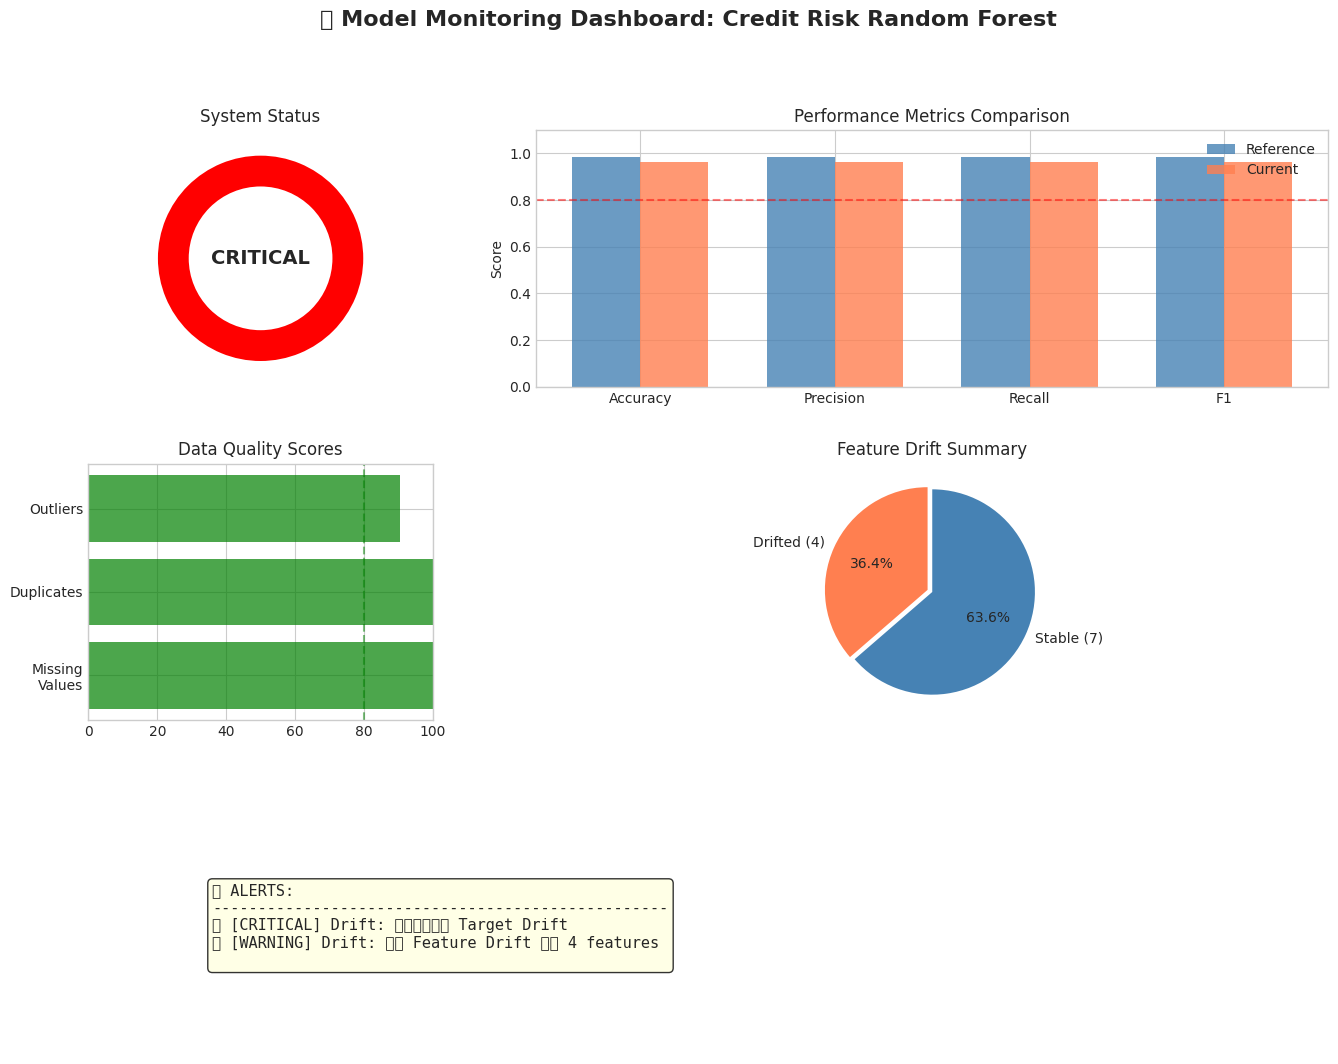

In [39]:
# แสดง Visual Dashboard
dashboard.plot_dashboard()

In [40]:
# Export Report
exported_report = dashboard.export_report()
print("\n📋 Exported Report Summary:")
for key, value in exported_report.items():
    if key != 'alerts':
        print(f"   {key}: {value}")

📄 Report exported: monitoring_report_20260107_040153

📋 Exported Report Summary:
   model_name: Credit Risk Random Forest
   timestamp: 2026-01-07T04:01:53.000680
   data_quality: {'missing_columns': 0, 'duplicates': {'duplicate_rows': 0, 'duplicate_percentage': np.float64(0.0), 'duplicate_ids': {}}}
   performance: {'reference': {'accuracy': 0.984, 'precision': 0.983923715392975, 'recall': 0.984, 'f1': 0.9838821398124468}, 'current': {'accuracy': 0.963, 'precision': 0.9619818707526063, 'recall': 0.963, 'f1': 0.9616770548087676}}
   drift: {'target_drift_detected': np.True_, 'feature_drift_count': 4}
   overall_status: CRITICAL


---
# 🎓 Section 5: สรุปและแนวทางปฏิบัติ
## Summary and Best Practices

## 5.1 สรุปสิ่งที่เรียนรู้

ใน LAB นี้ เราได้เรียนรู้เกี่ยวกับ Model Monitoring ดังนี้:

### 1. Data Quality Monitoring
- ตรวจสอบ missing values, duplicates, outliers
- สร้าง quality scores และ alerts
- ใช้ threshold-based monitoring

### 2. Model Performance Tracking
- ติดตาม classification metrics (Accuracy, Precision, Recall, F1)
- เปรียบเทียบ baseline vs current performance
- ตรวจจับ performance degradation

### 3. Drift Detection
- ใช้ statistical tests (KS, Chi-square, PSI)
- ตรวจจับ feature drift และ target drift
- สร้าง prediction drift analysis

### 4. Monitoring Dashboard
- รวม metrics ทั้งหมดใน single view
- สร้าง alerts และ recommendations
- Export reports สำหรับ stakeholders

## 5.2 Best Practices สำหรับ Model Monitoring

1. กำหนด Baseline ที่ชัดเจน
- บันทึก performance metrics เมื่อ deploy
- เก็บ reference data distribution

2. Monitor อย่างสม่ำเสมอ
- ตั้ง schedule สำหรับ monitoring (รายวัน/รายสัปดาห์)
- Automate monitoring pipeline

3. ตั้ง Threshold ที่เหมาะสม
- ไม่ sensitive เกินไป (false alarms)
- ไม่ loose เกินไป (miss real issues)

4. มี Action Plan
- กำหนดว่าจะทำอะไรเมื่อเกิด alert
- Retrain strategy เมื่อ performance ต่ำกว่าเกณฑ์

5. Document Everything
- บันทึก monitoring results
- Track model versions และ changes

In [41]:
# สรุป Code สำหรับ Quick Monitoring
def quick_model_monitor(model, scaler, reference_data, current_data, target_col):
    """
    ฟังก์ชันสำหรับ quick monitoring
    ใช้สำหรับตรวจสอบโมเดลอย่างรวดเร็ว
    """
    print("🚀 Quick Model Monitoring")
    print("=" * 50)

    # Prepare data
    X_ref, y_ref = prepare_features(reference_data, target_col)
    X_curr, y_curr = prepare_features(current_data, target_col)

    X_ref_scaled = scaler.transform(X_ref)
    X_curr_scaled = scaler.transform(X_curr)

    # Predictions
    y_pred_ref = model.predict(X_ref_scaled)
    y_pred_curr = model.predict(X_curr_scaled)

    # Calculate metrics
    ref_acc = accuracy_score(y_ref, y_pred_ref)
    curr_acc = accuracy_score(y_curr, y_pred_curr)
    degradation = (ref_acc - curr_acc) / ref_acc * 100

    # Target drift
    ref_rate = y_ref.mean()
    curr_rate = y_curr.mean()
    rate_change = abs(curr_rate - ref_rate)

    # Print summary
    print(f"📊 Reference Accuracy: {ref_acc:.4f}")
    print(f"📊 Current Accuracy:   {curr_acc:.4f}")
    print(f"📉 Degradation:        {degradation:.2f}%")
    print()
    print(f"🎯 Reference Target Rate: {ref_rate:.2%}")
    print(f"🎯 Current Target Rate:   {curr_rate:.2%}")
    print(f"📈 Rate Change:           {rate_change:.2%}")
    print()

    # Status
    if degradation > 10 or rate_change > 0.1:
        print("🔴 Status: CRITICAL - Consider retraining!")
    elif degradation > 5 or rate_change > 0.05:
        print("🟡 Status: WARNING - Monitor closely")
    else:
        print("🟢 Status: HEALTHY - Model performing well")

    print("=" * 50)

    return {
        'reference_accuracy': ref_acc,
        'current_accuracy': curr_acc,
        'degradation_pct': degradation,
        'reference_target_rate': ref_rate,
        'current_target_rate': curr_rate,
        'rate_change': rate_change
    }

In [42]:
# ทดสอบ Quick Monitor
print("\n📊 ทดสอบ Quick Model Monitor:")
quick_results = quick_model_monitor(rf_model, scaler, reference_data, current_data, 'default')


📊 ทดสอบ Quick Model Monitor:
🚀 Quick Model Monitoring
📊 Reference Accuracy: 0.9840
📊 Current Accuracy:   0.9630
📉 Degradation:        2.13%

🎯 Reference Target Rate: 18.75%
🎯 Current Target Rate:   12.50%
📈 Rate Change:           6.25%

🟡 Status: WARNING - Monitor closely


## 5.3 แบบฝึกหัด (Exercises)

ลองทำแบบฝึกหัดต่อไปนี้เพื่อทดสอบความเข้าใจ:

1. Exercise 1: เพิ่ม drift level เป็น 0.5 และ 0.7 แล้วดูผลกระทบต่อ performance

2. Exercise 2: ปรับ threshold ของ alerts และดูว่า alerts เปลี่ยนแปลงอย่างไร

3. Exercise 3: เพิ่ม metric ใหม่ เช่น AUC-ROC ใน performance monitoring

4. Exercise 4: สร้าง monitoring สำหรับ regression model แทน classification

In [43]:
# Exercise 1: ทดสอบกับ drift level ที่สูงขึ้น
print("📝 Exercise 1: ทดสอบกับ High Drift Data")
print()

high_drift_data = create_credit_data(n_samples=1000, seed=456, drift_level=0.7)
print("High Drift Data (drift_level=0.7):")
quick_results_high = quick_model_monitor(rf_model, scaler, reference_data, high_drift_data, 'default')

📝 Exercise 1: ทดสอบกับ High Drift Data

High Drift Data (drift_level=0.7):
🚀 Quick Model Monitoring
📊 Reference Accuracy: 0.9840
📊 Current Accuracy:   0.9630
📉 Degradation:        2.13%

🎯 Reference Target Rate: 18.75%
🎯 Current Target Rate:   8.70%
📈 Rate Change:           10.05%

🔴 Status: CRITICAL - Consider retraining!


---
# 🎉 จบ LAB: Model Monitoring with Scikit-Learn

## สิ่งที่ได้เรียนรู้:

1. ✅ Data Quality Monitoring
- ตรวจสอบ missing values, duplicates, outliers
- สร้าง quality reports และ alerts

2. ✅ Model Performance Tracking
- ติดตาม classification/regression metrics
- เปรียบเทียบ reference vs current performance

3. ✅ Drift Detection
- ใช้ statistical tests (KS, Chi-square, PSI)
- ตรวจจับ feature drift และ target drift

4. ✅ Monitoring Dashboard
- สร้าง comprehensive dashboard
- Generate alerts และ reports

## ขั้นตอนถัดไป:

- นำ monitoring ไปใช้กับ production model
- ตั้ง automated monitoring pipeline
- เชื่อมต่อกับ alerting system (email, Slack)
- สร้าง retraining pipeline เมื่อ performance ต่ำ

In [44]:
print("🎉 จบ LAB: Model Monitoring with Scikit-Learn")
print()
print("ขอบคุณที่เรียนรู้ไปด้วยกัน!")
print("Happy Monitoring! 🚀")

🎉 จบ LAB: Model Monitoring with Scikit-Learn

ขอบคุณที่เรียนรู้ไปด้วยกัน!
Happy Monitoring! 🚀
